# Business Understanding

**Problem**

Sebuah perusahaan financial memiliki `8%` kreditur yang default. Masalah ini dapat menyebabkan kerugian sebesar `$138.46.851.949`. Perusahaan ingin Tim Data Scientist berkolaborasi dengan financial analyst untuk menyelsaikan masalah ini. Perusahaan ingin memberikan bunga dan kredit limit yang tepat untuk meminimalisir kerugian.

**Business Metrics**

    1. Meminimalisir kerugian yang disebabkan kreditur yang default
    2. Mengurangi jumlah kreditur yang default

**Goals**

    1. Membuat model yang dapat melakukan scoring kredit applicant sebagai pertimbangan untuk menentukan bunga dan kredit limit yang tepat

# Feature Engineering

## Train App

In [701]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [702]:
import pandas as pd
df_train_selected = pd.read_csv('train_selected.csv')
df_train = pd.read_csv('application_train.csv')
column_selected = df_train_selected.columns.tolist()
df_train = df_train[column_selected]

In [703]:
def preprocessing(df):
    """"
    Objective :
    Function for preprocessing data, known missing, duplicated values and basic stastics every column in dataframe and duplicated row
    df is dataframe
    """
    try:
        import pandas as pd
        variables = pd.DataFrame(columns=['Variable','Number of unique values','Percent of Null(%)','Number of Duplicated','Type','Values'])
        for i, var in enumerate(df.columns):
            variables.loc[i] = [var, df[var].nunique(),df[var].isnull().sum()/df.shape[0]*100,df[var].duplicated(keep=False).sum(),df[var].dtypes,df[var].unique()]
        return (variables.set_index('Variable'))
    except:
        print('ada kesalahan penginputan')

In [704]:
df_train['AGE'] = -df_train['DAYS_BIRTH']/365
df_train['WORKDAY'] =  -df_train['DAYS_EMPLOYED']/365
df_train.drop(['DAYS_BIRTH','DAYS_EMPLOYED'],axis=1,inplace=True)

## Prev App

## Contract Type

In [705]:
prev_app = pd.read_csv('prev_select.csv')

In [706]:
prev_app['NAME_CONTRACT_TYPE'].unique()

array(['Consumer loans', 'Cash loans', 'Revolving loans', 'XNA'],
      dtype=object)

In [707]:
prev_app.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_CREDIT',
       'FLAG_LAST_APPL_PER_CONTRACT', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'NAME_CONTRACT_STATUS', 'NAME_PORTFOLIO'],
      dtype='object')

In [708]:
consumer_loans = prev_app[prev_app['NAME_CONTRACT_TYPE']=='Consumer loans']
consumer_loans = consumer_loans.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
consumer_loans = consumer_loans.reset_index()
consumer_loans['Consumer Loans'] = consumer_loans['SK_ID_PREV']
consumer_loans.drop('SK_ID_PREV',axis=1,inplace=True)
df_train = df_train.merge(consumer_loans,how='left',on='SK_ID_CURR')

In [709]:
cash_loans = prev_app[prev_app['NAME_CONTRACT_TYPE']=='Cash loans']
cash_loans = cash_loans.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
cash_loans = cash_loans.reset_index()
cash_loans['Cash Loans'] = cash_loans['SK_ID_PREV']
cash_loans.drop('SK_ID_PREV',axis=1,inplace=True)
df_train = df_train.merge(cash_loans,how='left',on='SK_ID_CURR')

In [710]:
revolving_loans = prev_app[prev_app['NAME_CONTRACT_TYPE']=='Revolving loans']
revolving_loans = revolving_loans.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
revolving_loans = revolving_loans.reset_index()
revolving_loans['Revolving Loans'] = revolving_loans['SK_ID_PREV']
revolving_loans.drop('SK_ID_PREV',axis=1,inplace=True)
df_train = df_train.merge(revolving_loans,how='left',on='SK_ID_CURR')

## Aproved Credit

### High Approved Credit

In [711]:
high_approved_credit = prev_app.groupby('SK_ID_CURR')['AMT_CREDIT'].max().reset_index()
high_approved_credit['HIGH_APPROVED_CREDIT'] = high_approved_credit['AMT_CREDIT']
high_approved_credit.drop('AMT_CREDIT',axis=1,inplace=True)
df_train = df_train.merge(high_approved_credit,how='left',on='SK_ID_CURR')

### Average Approved Credit

In [712]:
average_approved_credit = prev_app.groupby('SK_ID_CURR')['AMT_CREDIT'].mean().reset_index()
average_approved_credit['AVERAGE_APPROVED_CREDIT'] = average_approved_credit['AMT_CREDIT']
average_approved_credit.drop('AMT_CREDIT',axis=1,inplace=True)
df_train = df_train.merge(average_approved_credit,how='left',on='SK_ID_CURR')

## Flag

In [713]:
flag = prev_app[prev_app['FLAG_LAST_APPL_PER_CONTRACT']=='Y']
flag = flag.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().reset_index()
flag['FLAG'] = flag['SK_ID_PREV']
flag.drop('SK_ID_PREV',axis=1,inplace=True)
df_train = df_train.merge(flag,how='left',on='SK_ID_CURR')

## Downpayment

In [714]:
high_downpayment = prev_app.groupby('SK_ID_CURR')['RATE_DOWN_PAYMENT'].max().reset_index()
high_downpayment['HIGH_RATE_DOWN_PAYMENT'] = high_downpayment['RATE_DOWN_PAYMENT']
high_downpayment.drop('RATE_DOWN_PAYMENT',axis=1,inplace=True)
df_train = df_train.merge(high_downpayment,how='left',on='SK_ID_CURR')

In [715]:
average_downpayment = prev_app.groupby('SK_ID_CURR')['RATE_DOWN_PAYMENT'].mean().reset_index()
average_downpayment['AVERAGE_RATE_DOWN_PAYMENT'] = average_downpayment['RATE_DOWN_PAYMENT']
average_downpayment.drop('RATE_DOWN_PAYMENT',axis=1,inplace=True)
df_train = df_train.merge(average_downpayment,how='left',on='SK_ID_CURR')

## Name Portofolio

In [716]:
prev_app['NAME_PORTFOLIO'].value_counts()

POS      691011
Cash     461563
XNA      372230
Cards    144985
Cars        425
Name: NAME_PORTFOLIO, dtype: int64

In [717]:
cards = prev_app[prev_app['NAME_PORTFOLIO']=='Cards']
cards = cards.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
cards = cards.reset_index()
cards['Cards'] = cards['SK_ID_PREV']
cards.drop('SK_ID_PREV',axis=1,inplace=True)
df_train = df_train.merge(cards,how='left',on='SK_ID_CURR')

In [718]:
POS = prev_app[prev_app['NAME_PORTFOLIO']=='POS']
POS = POS.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
POS = POS.reset_index()
POS['POS'] = POS['SK_ID_PREV']
POS.drop('SK_ID_PREV',axis=1,inplace=True)
df_train = df_train.merge(POS,how='left',on='SK_ID_CURR')

In [719]:
Cash = prev_app[prev_app['NAME_PORTFOLIO']=='Cash']
Cash = Cash.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
Cash = Cash.reset_index()
Cash['Cash'] = Cash['SK_ID_PREV']
Cash.drop('SK_ID_PREV',axis=1,inplace=True)
df_train = df_train.merge(Cash,how='left',on='SK_ID_CURR')

## Bureau

In [720]:
bureau = pd.read_csv('bureau_selected.csv')
bureau.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_DAY_OVERDUE',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE'],
      dtype='object')

### Credit Type

In [721]:
bureau['CREDIT_TYPE'].value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: CREDIT_TYPE, dtype: int64

In [722]:
credit_active = bureau[bureau['CREDIT_ACTIVE']=='Active']
credit_active = credit_active.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique().reset_index()
credit_active['CREDIT_ACTIVE'] = credit_active['SK_ID_BUREAU']
credit_active.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_train = df_train.merge(credit_active,how='left',on='SK_ID_CURR')

In [723]:
credit_overdue = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].sum().reset_index()
df_train = df_train.merge(credit_overdue,how='left',on='SK_ID_CURR')

In [724]:
credit_card = bureau[bureau['CREDIT_TYPE']=='Credit card']
credit_card = credit_card.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()
credit_card = credit_card.reset_index()
credit_card['Credit card'] = credit_card['SK_ID_BUREAU']
credit_card.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_train = df_train.merge(credit_card,how='left',on='SK_ID_CURR')

In [725]:
consumer_credit = bureau[bureau['CREDIT_TYPE']=='Consumer credit']
consumer_credit = consumer_credit.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()
consumer_credit = consumer_credit.reset_index()
consumer_credit['Consumer credit'] = consumer_credit['SK_ID_BUREAU']
consumer_credit.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_train = df_train.merge(consumer_credit,how='left',on='SK_ID_CURR')

In [726]:
car_loan = bureau[bureau['CREDIT_TYPE']=='Car loan']
car_loan = car_loan.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()
car_loan = car_loan.reset_index()
car_loan['Car loan'] = car_loan['SK_ID_BUREAU']
car_loan.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_train = df_train.merge(car_loan,how='left',on='SK_ID_CURR')

In [727]:
Mortgage = bureau[bureau['CREDIT_TYPE']=='Mortgage']
Mortgage = Mortgage.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()
Mortgage = Mortgage.reset_index()
Mortgage['Mortgage'] = Mortgage['SK_ID_BUREAU']
Mortgage.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_train = df_train.merge(Mortgage,how='left',on='SK_ID_CURR')

In [728]:
Microloan = bureau[bureau['CREDIT_TYPE']=='Microloan']
Microloan = Microloan.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()
Microloan = Microloan.reset_index()
Microloan['Microloan'] = Microloan['SK_ID_BUREAU']
Microloan.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_train = df_train.merge(Microloan,how='left',on='SK_ID_CURR')

## Installment

In [729]:
installment = pd.read_csv('installments.csv')

In [730]:
installment.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

In [731]:
installment['PAY_INST'] = installment['AMT_INSTALMENT']-installment['AMT_PAYMENT']

In [732]:
installment['PAY_DAY'] = installment['DAYS_INSTALMENT']-installment['DAYS_ENTRY_PAYMENT']

In [733]:
PAY_DAY = installment[['SK_ID_CURR','SK_ID_PREV','PAY_DAY']]
PAYDAY_1 = PAY_DAY[(PAY_DAY['PAY_DAY']<1)&(PAY_DAY['PAY_DAY']>=-30)]
PAYDAY_1 = PAYDAY_1.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().reset_index()
PAYDAY_1['PAY_INST_1'] = PAYDAY_1['SK_ID_PREV']
PAYDAY_1.drop('SK_ID_PREV',axis=1,inplace=True)
df_train = df_train.merge(PAYDAY_1,how='left',on='SK_ID_CURR')

In [734]:
PAY_DAY = installment[['SK_ID_CURR','SK_ID_PREV','PAY_DAY']]
PAYDAY_30 = PAY_DAY[(PAY_DAY['PAY_DAY']<30)]
PAYDAY_30 = PAYDAY_30.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().reset_index()
PAYDAY_30['PAY_INST_30'] = PAYDAY_30['SK_ID_PREV']
PAYDAY_30.drop('SK_ID_PREV',axis=1,inplace=True)
df_train = df_train.merge(PAYDAY_30,how='left',on='SK_ID_CURR')

In [735]:
posh = pd.read_csv('POSH_selected.csv')
posh['CNT_DIFF'] = posh['CNT_INSTALMENT_FUTURE']-posh['CNT_INSTALMENT']

In [736]:
active = posh[posh['NAME_CONTRACT_STATUS']=='Active']

In [737]:
cnt_diff = posh.groupby('SK_ID_CURR')['CNT_DIFF'].sum().reset_index()
df_train = df_train.merge(cnt_diff,how='left',on='SK_ID_CURR')

# Preprocessing

## Handling Missing Value

In [738]:
preprocessing(df_train)

,Number of unique values,Percent of Null(%),Number of Duplicated,Type,Values
Variable,,,,,
SK_ID_CURR,307511,0.000000,0,int64,"[100002, 100003, 100004, 100006, 100007, 10000..."
TARGET,2,0.000000,307511,int64,"[1, 0]"
FLAG_OWN_CAR,2,0.000000,307511,object,"[N, Y]"
CNT_CHILDREN,15,0.000000,307510,int64,"[0, 1, 2, 3, 4, 7, 5, 6, 8, 9, 11, 12, 10, 19,..."
AMT_INCOME_TOTAL,2548,0.000000,305665,float64,"[202500.0, 270000.0, 67500.0, 135000.0, 121500..."
NAME_TYPE_SUITE,7,0.420148,307511,object,"[Unaccompanied, Family, Spouse, partner, Child..."
NAME_INCOME_TYPE,8,0.000000,307511,object,"[Working, State servant, Commercial associate,..."
NAME_EDUCATION_TYPE,5,0.000000,307511,object,"[Secondary / secondary special, Higher educati..."
NAME_FAMILY_STATUS,6,0.000000,307511,object,"[Single / not married, Married, Civil marriage..."


In [739]:
null = ['OWN_CAR_AGE','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR','Consumer Loans','Cash Loans','HIGH_APPROVED_CREDIT','Cards',
       'Cards','POS','Cash','CREDIT_ACTIVE','CREDIT_DAY_OVERDUE','Consumer credit','Credit card','Car loan','Mortgage',
       'PAY_INST_30','Microloan','PAY_INST_60','PAY_INST_1','CNT_DIFF','HIGH_RATE_DOWN_PAYMENT',
       'AVERAGE_RATE_DOWN_PAYMENT']

In [740]:
df_train = df_train.fillna(value=0)

**Data Insight**

null value menunjukan bahwa belum ada nilainya sehingga diisi dengan 0

In [741]:
df_train.duplicated().sum()

0

**Data Insight**

tidak ada data yang duplikat

## Handling Outlier

In [742]:
preprocessing(df_train)

,Number of unique values,Percent of Null(%),Number of Duplicated,Type,Values
Variable,,,,,
SK_ID_CURR,307511,0.0,0,int64,"[100002, 100003, 100004, 100006, 100007, 10000..."
TARGET,2,0.0,307511,int64,"[1, 0]"
FLAG_OWN_CAR,2,0.0,307511,object,"[N, Y]"
CNT_CHILDREN,15,0.0,307510,int64,"[0, 1, 2, 3, 4, 7, 5, 6, 8, 9, 11, 12, 10, 19,..."
AMT_INCOME_TOTAL,2548,0.0,305665,float64,"[202500.0, 270000.0, 67500.0, 135000.0, 121500..."
NAME_TYPE_SUITE,8,0.0,307511,object,"[Unaccompanied, Family, Spouse, partner, Child..."
NAME_INCOME_TYPE,8,0.0,307511,object,"[Working, State servant, Commercial associate,..."
NAME_EDUCATION_TYPE,5,0.0,307511,object,"[Secondary / secondary special, Higher educati..."
NAME_FAMILY_STATUS,6,0.0,307511,object,"[Single / not married, Married, Civil marriage..."


In [743]:
numeric = ['AMT_INCOME_TOTAL','AGE','WORKDAY','AVERAGE_APPROVED_CREDIT','HIGH_APPROVED_CREDIT','HIGH_RATE_DOWN_PAYMENT','AVERAGE_RATE_DOWN_PAYMENT','OWN_CAR_AGE']

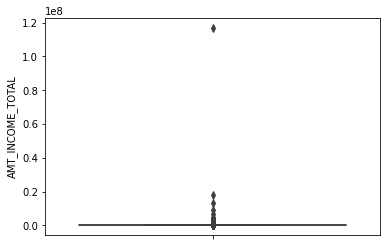

<Figure size 216x216 with 0 Axes>

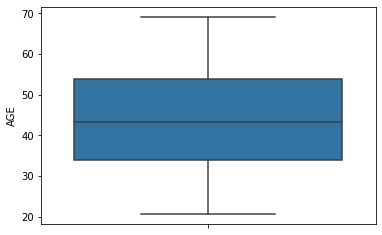

<Figure size 216x216 with 0 Axes>

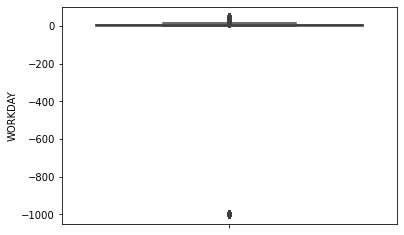

<Figure size 216x216 with 0 Axes>

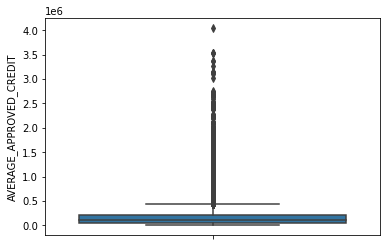

<Figure size 216x216 with 0 Axes>

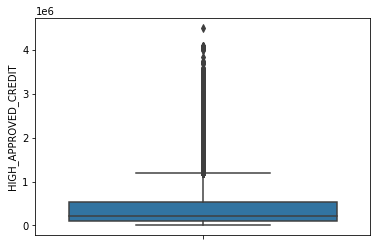

<Figure size 216x216 with 0 Axes>

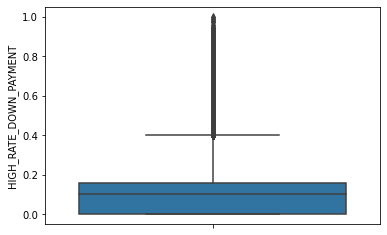

<Figure size 216x216 with 0 Axes>

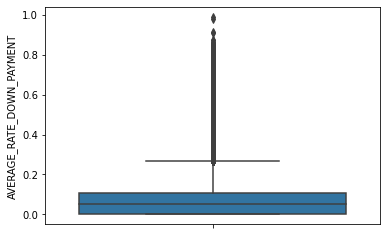

<Figure size 216x216 with 0 Axes>

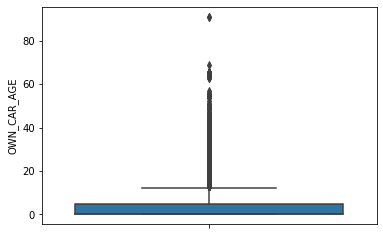

<Figure size 216x216 with 0 Axes>

In [744]:
    for j in range (0,len(numeric)):
        num = numeric[j]
        sns.boxplot(y=df_train[num])
        plt.figure(figsize=(3,3))
        plt.show()

In [745]:
Q1 = df_train['AMT_INCOME_TOTAL'].quantile(0.25)
Q3 = df_train['AMT_INCOME_TOTAL'].quantile(0.75)
IQR = Q3-Q1
low_limit = Q1 - (1.5*IQR)
high_limit = Q3 + (1.5*IQR)
filtered_entries = ((df_train['AMT_INCOME_TOTAL']>=low_limit)&(df_train['AMT_INCOME_TOTAL']<=high_limit))
df_clean_IQR = df_train
df_clean_IQR = df_clean_IQR[filtered_entries]
df_clean_IQR.shape[0]

293476

In [746]:
Q1 = df_clean_IQR['WORKDAY'].quantile(0.25)
Q3 = df_clean_IQR['WORKDAY'].quantile(0.75)
IQR = Q3-Q1
low_limit = Q1 - (1.5*IQR)
high_limit = Q3 + (1.5*IQR)
filtered_entries = ((df_clean_IQR['WORKDAY']>=low_limit)&(df_clean_IQR['WORKDAY']<=high_limit))
df_clean_IQR = df_clean_IQR
df_clean_IQR = df_clean_IQR[filtered_entries]
df_clean_IQR.shape[0]

223008

In [747]:
print('Data yang dipakai',round(df_clean_IQR.shape[0]/df_train.shape[0]*100,2),'%')

Data yang dipakai 72.52 %


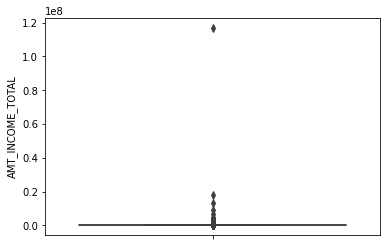

<Figure size 216x216 with 0 Axes>

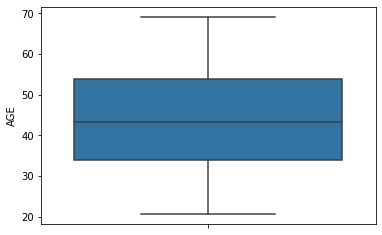

<Figure size 216x216 with 0 Axes>

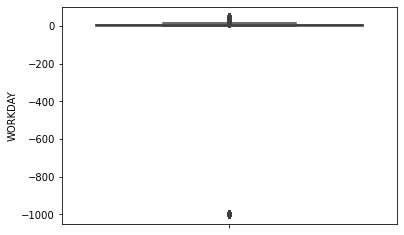

<Figure size 216x216 with 0 Axes>

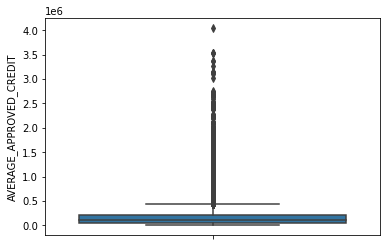

<Figure size 216x216 with 0 Axes>

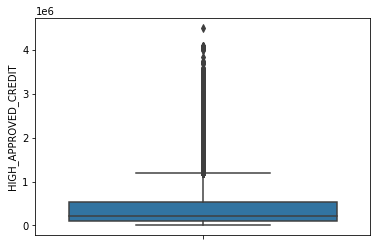

<Figure size 216x216 with 0 Axes>

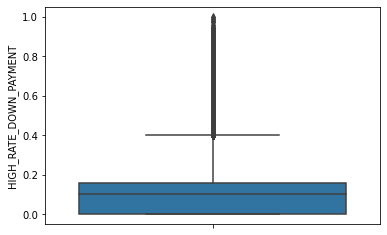

<Figure size 216x216 with 0 Axes>

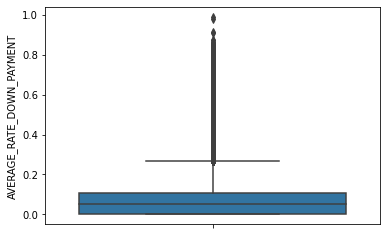

<Figure size 216x216 with 0 Axes>

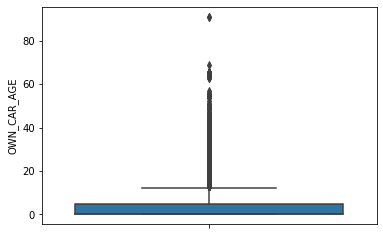

<Figure size 216x216 with 0 Axes>

In [748]:
    for j in range (0,len(numeric)):
        num = numeric[j]
        sns.boxplot(y=df_train[num])
        plt.figure(figsize=(3,3))
        plt.show()

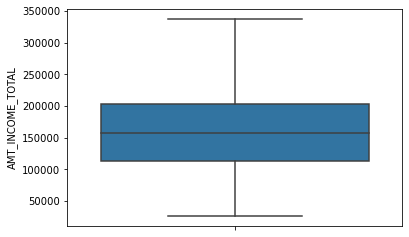

<Figure size 216x216 with 0 Axes>

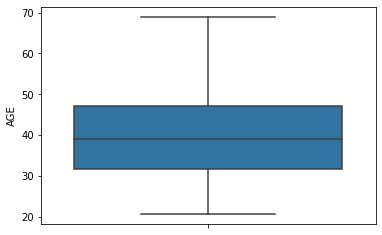

<Figure size 216x216 with 0 Axes>

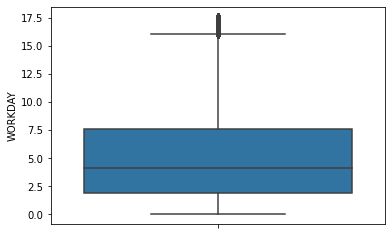

<Figure size 216x216 with 0 Axes>

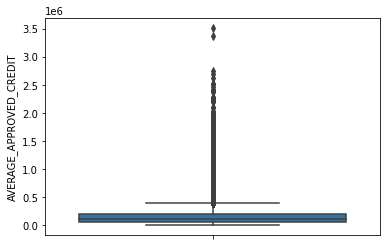

<Figure size 216x216 with 0 Axes>

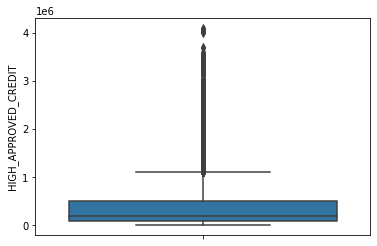

<Figure size 216x216 with 0 Axes>

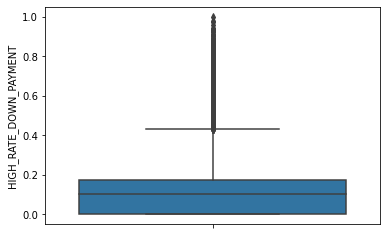

<Figure size 216x216 with 0 Axes>

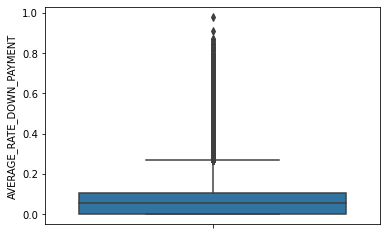

<Figure size 216x216 with 0 Axes>

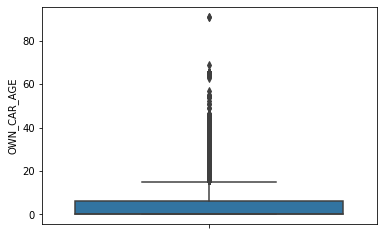

<Figure size 216x216 with 0 Axes>

In [749]:
    for j in range (0,len(numeric)):
        num = numeric[j]
        sns.boxplot(y=df_clean_IQR[num])
        plt.figure(figsize=(3,3))
        plt.show()

## Univariate Analysis

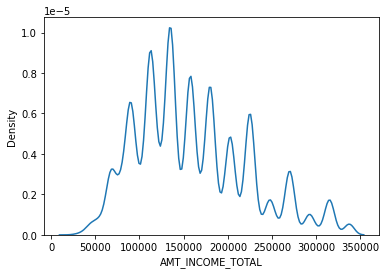

<Figure size 216x216 with 0 Axes>

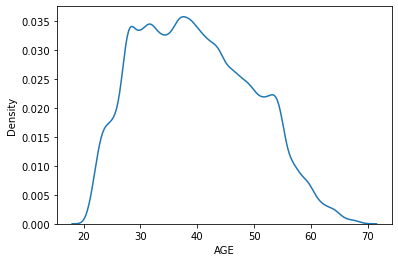

<Figure size 216x216 with 0 Axes>

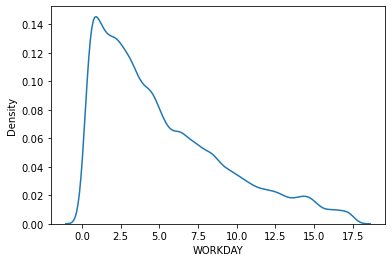

<Figure size 216x216 with 0 Axes>

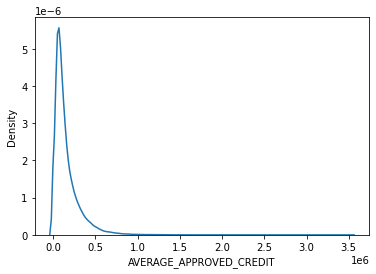

<Figure size 216x216 with 0 Axes>

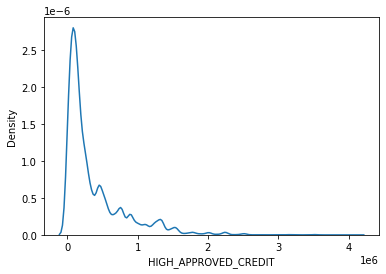

<Figure size 216x216 with 0 Axes>

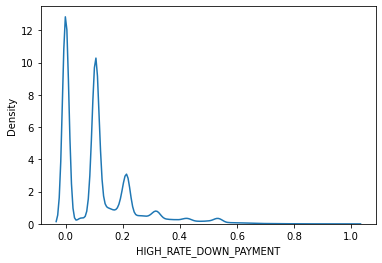

<Figure size 216x216 with 0 Axes>

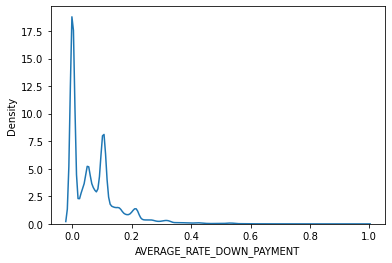

<Figure size 216x216 with 0 Axes>

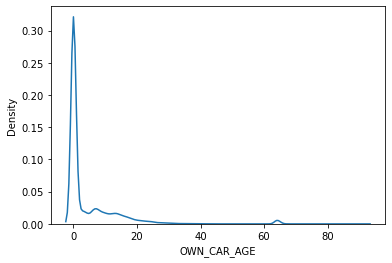

<Figure size 216x216 with 0 Axes>

In [750]:
    for j in range (0,len(numeric)):
        num = numeric[j]
        sns.kdeplot(x=df_clean_IQR[num])
        plt.figure(figsize=(3,3))
        plt.show()

**Data Insight**

banyak data yang memiliki positive skew

In [751]:
df_train.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AGE',
 'WORKDAY',
 'Consumer Loans',
 'Cash Loans',
 'Revolving Loans',
 'HIGH_APPROVED_CREDIT',
 'AVERAGE_APPROVED_CREDIT',
 'FLAG',
 'HIGH_RATE_DOWN_PAYMENT',
 'AVERAGE_RATE_DOWN_PAYMENT',
 'Cards',
 'POS',
 'Cash',
 'CREDIT_ACTIVE',
 'CREDIT_DAY_OVERDUE',
 'Credit card',
 'Consumer credit',
 'Car loan',
 'Mortgage',
 'Microloan',
 'PAY_INST_1',
 'PAY_INST_30',
 'CNT_DIFF']

## Multivariate Analysis

In [752]:
corr_matrix = df_clean_IQR.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop_hicorr = [column for column in upper.columns if any(upper[column] > 0.7)]

In [753]:
to_drop_hicorr

['CNT_FAM_MEMBERS',
 'AVERAGE_APPROVED_CREDIT',
 'FLAG',
 'AVERAGE_RATE_DOWN_PAYMENT',
 'Cards',
 'POS',
 'Cash',
 'Credit card',
 'PAY_INST_30']

In [754]:
df_clean_IQR.drop(to_drop_hicorr, axis=1, inplace=True)

In [755]:
df_train = df_clean_IQR

In [756]:
df_train['NAME_TYPE_SUITE'] = df_train['NAME_TYPE_SUITE'].replace(0,'Unaccompanied')
df_train['OCCUPATION_TYPE'] = df_train['OCCUPATION_TYPE'].replace(0,'Others')

In [757]:
df_train.to_csv('train_features.csv')

In [758]:
df_train.drop('SK_ID_CURR',axis=1,inplace=True)

## Bivariate Analysis

## WOE and IV

In [57]:
features = df_train.drop(['TARGET'],axis=1)
labels = df_train['TARGET']

In [58]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [59]:
final_iv, IV = data_vars(features,labels)

C:\Users\Muhammad Hanif\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [60]:
df_train['TARGET'].value_counts()

0    202657
1     20351
Name: TARGET, dtype: int64

In [61]:
final_iv.sort_values('IV',ascending=False)

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
51,OCCUPATION_TYPE,Managers,Managers,15684,1020,0.065034,14664,0.934966,0.050120,0.072359,-0.367208,0.066873
44,OCCUPATION_TYPE,Core staff,Core staff,23261,1577,0.067796,21684,0.932204,0.077490,0.106999,-0.322666,0.066873
52,OCCUPATION_TYPE,Medicine staff,Medicine staff,6715,498,0.074162,6217,0.925838,0.024471,0.030677,-0.226058,0.066873
57,OCCUPATION_TYPE,Secretaries,Secretaries,1135,86,0.075771,1049,0.924229,0.004226,0.005176,-0.202860,0.066873
56,OCCUPATION_TYPE,Sales staff,Sales staff,30946,3011,0.097299,27935,0.902701,0.147953,0.137844,0.070777,0.066873
...,...,...,...,...,...,...,...,...,...,...,...,...
64,AMT_REQ_CREDIT_BUREAU_WEEK,0.0,1.0,222751,20331,0.091272,202420,0.908728,0.999017,0.998831,0.000187,0.000033
3,CNT_CHILDREN,2,19,27885,2570,0.092164,25315,0.907836,0.126284,0.124915,0.010894,0.000017
2,CNT_CHILDREN,0,1,195123,17781,0.091127,177342,0.908873,0.873716,0.875085,-0.001565,0.000017
61,AMT_REQ_CREDIT_BUREAU_HOUR,2.0,4.0,51,5,0.098039,46,0.901961,0.000246,0.000227,0.079181,0.000001


In [62]:
IV = IV.rename(columns={'VAR_NAME':'index'})
round((IV.sort_values(['IV'],ascending=0)),2)

,index,IV
26,OCCUPATION_TYPE,0.07
21,NAME_EDUCATION_TYPE,0.06
30,WORKDAY,0.06
0,AGE,0.04
18,HIGH_RATE_DOWN_PAYMENT,0.03
24,NAME_INCOME_TYPE,0.02
29,Revolving Loans,0.02
22,NAME_FAMILY_STATUS,0.02
15,Consumer credit,0.01
9,CNT_DIFF,0.01


C:\Users\Muhammad Hanif\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Muhammad Hanif\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


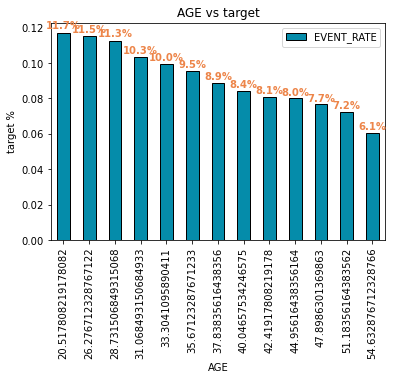

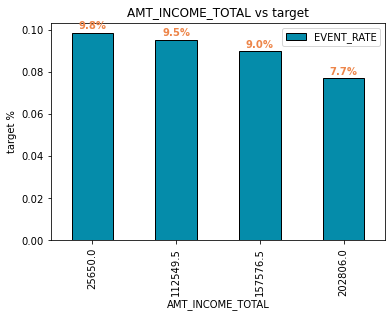

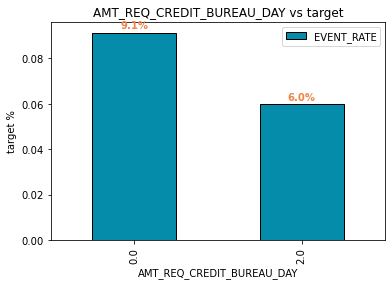

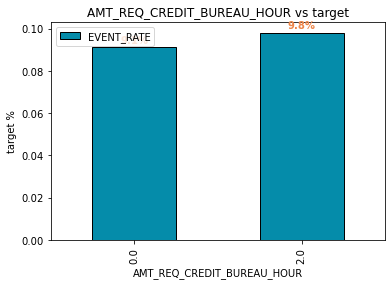

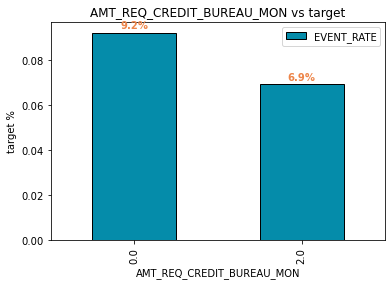

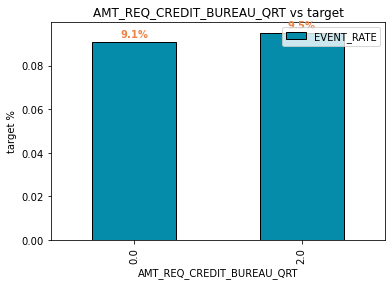

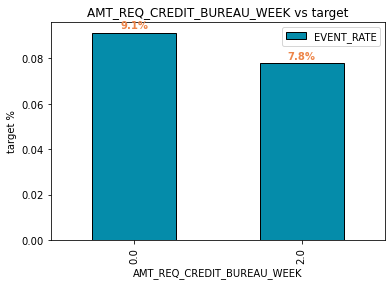

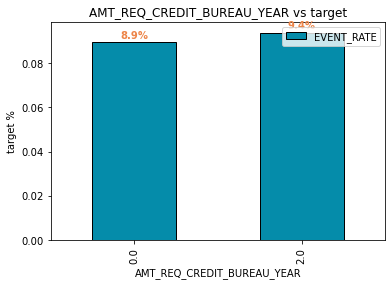

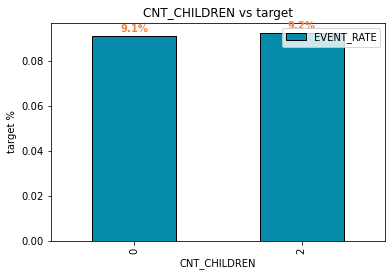

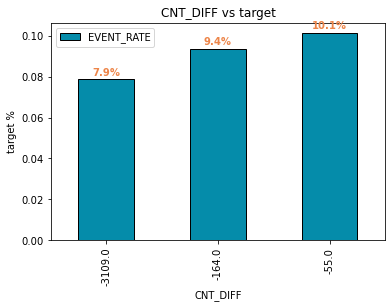

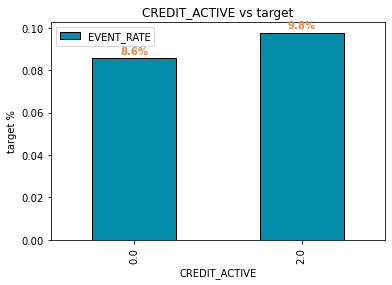

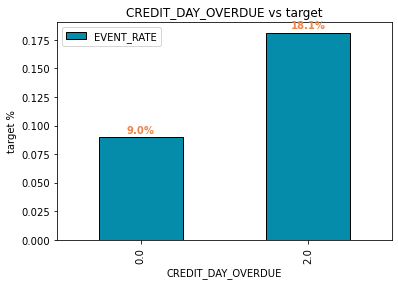

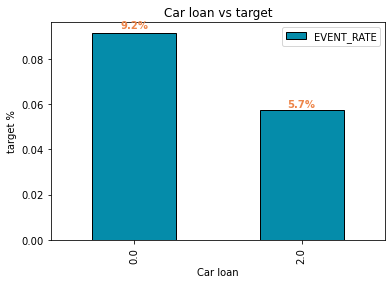

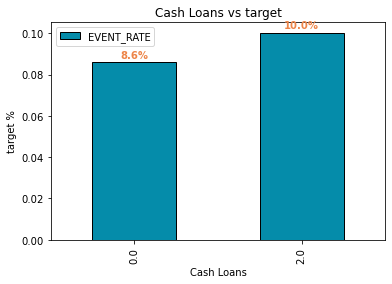

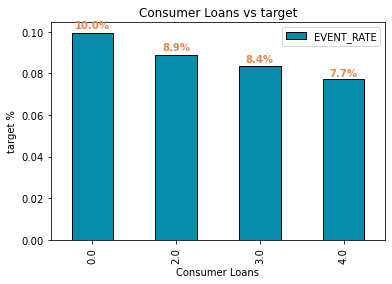

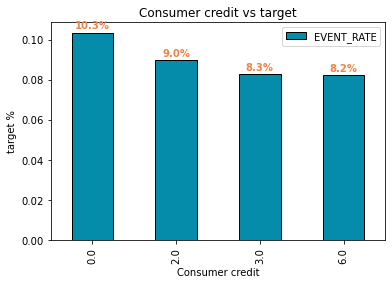

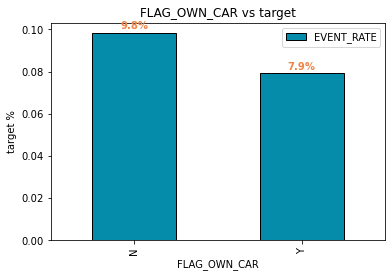

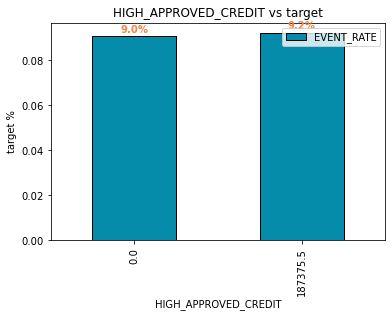

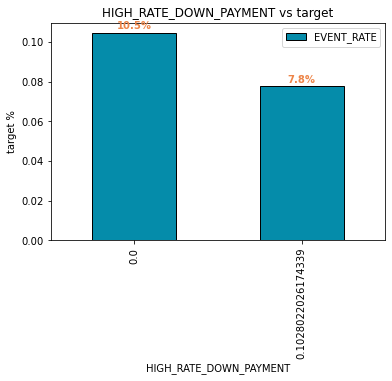

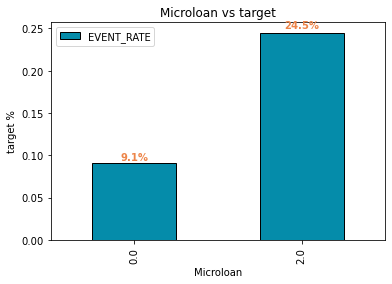

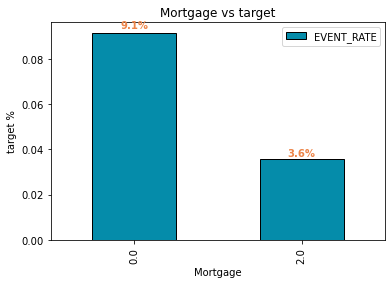

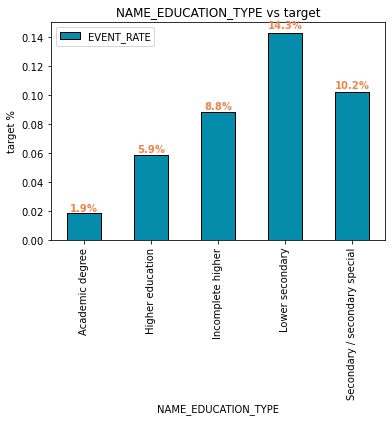

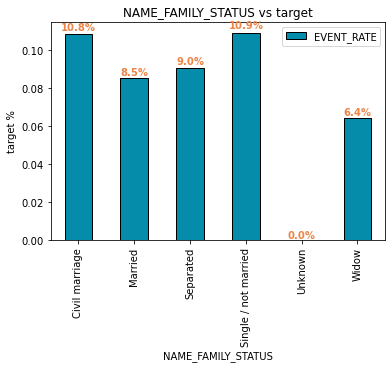

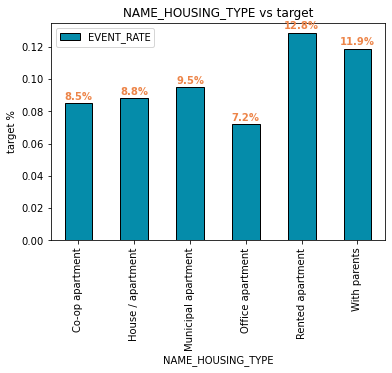

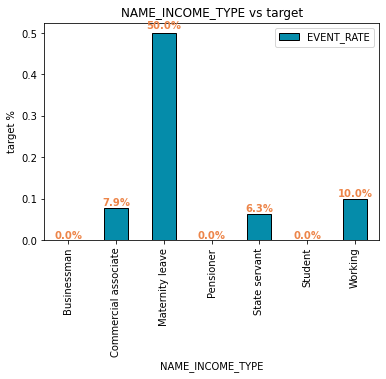

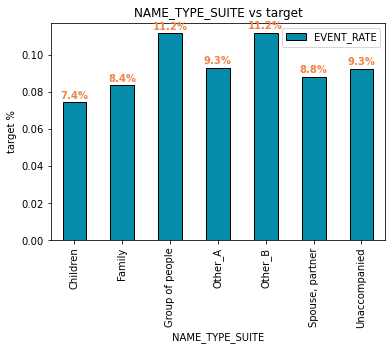

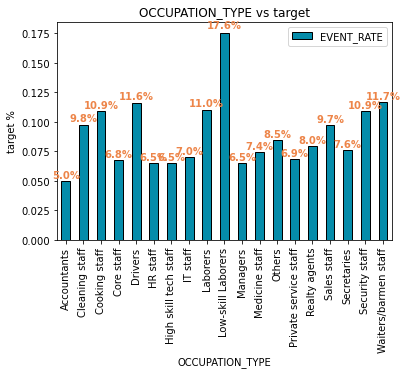

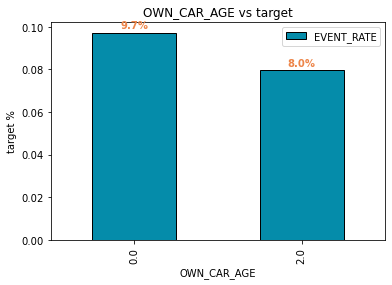

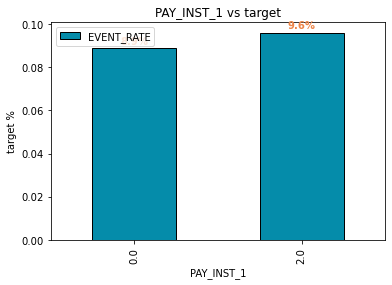

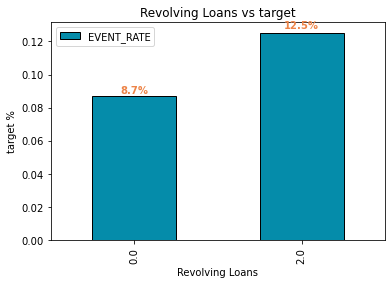

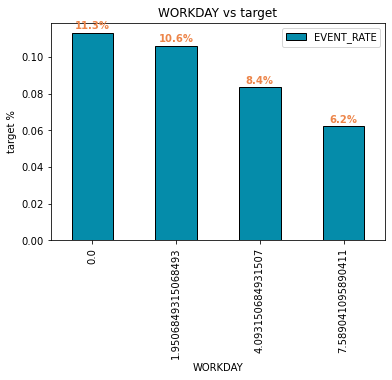

In [63]:
bar_color = '#058caa'
num_color = '#ed8549'

final_iv,_ = data_vars(df_train,df_train['TARGET'])
final_iv = final_iv[(final_iv.VAR_NAME != 'target')]
grouped = final_iv.groupby(['VAR_NAME'])
for key, group in grouped:
    ax = group.plot('MIN_VALUE','EVENT_RATE',kind='bar',color=bar_color,linewidth=1.0,edgecolor=['black'])
    ax.set_title(str(key) + " vs " + str('target'))
    ax.set_xlabel(key)
    ax.set_ylabel(str('target') + " %")
    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, str(round(height*100,1)) + '%', 
                ha='center', va='bottom', color=num_color, fontweight='bold')

**Data Insight**

Menurut WOE berikut ini kategori applicant yang memiliki kemungkinan default diatas 10%:
    
    1. AMT_REQ_CREDIT_BUREAU_HOUR = 2
    2. CREDIT_DAY_OVERDUE = 20%
    3. OCCUPATION_TYPE: Low-SKill_Labour

## Data Transform

In [64]:
df = df_train

In [65]:
transform_vars_list = df.columns.difference(['TARGET'])
transform_prefix = ''

In [66]:
transform_vars_list

Index(['AGE', 'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_CHILDREN', 'CNT_DIFF',
       'CREDIT_ACTIVE', 'CREDIT_DAY_OVERDUE', 'Car loan', 'Cash Loans',
       'Consumer Loans', 'Consumer credit', 'FLAG_OWN_CAR',
       'HIGH_APPROVED_CREDIT', 'HIGH_RATE_DOWN_PAYMENT', 'Microloan',
       'Mortgage', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE',
       'OCCUPATION_TYPE', 'OWN_CAR_AGE', 'PAY_INST_1', 'Revolving Loans',
       'WORKDAY'],
      dtype='object')

In [67]:
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd))
        except:
            df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd1))

# Modelling

In [797]:
df.columns.tolist()

['TARGET',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AGE',
 'WORKDAY',
 'Consumer Loans',
 'Cash Loans',
 'Revolving Loans',
 'HIGH_APPROVED_CREDIT',
 'HIGH_RATE_DOWN_PAYMENT',
 'CREDIT_ACTIVE',
 'CREDIT_DAY_OVERDUE',
 'Consumer credit',
 'Car loan',
 'Mortgage',
 'Microloan',
 'PAY_INST_1',
 'CNT_DIFF']

In [762]:
X = df.drop('TARGET',axis=1)
y= df['TARGET']

In [763]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
smote = SMOTE()
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=21)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [764]:
features_train = X_train
label_train = y_train
features_test = X_test
label_test = y_test

## Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]

from sklearn.metrics import accuracy_score
accuracy_train_lr = accuracy_score(pred_train,label_train)
accuracy_test_lr = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_lr = precision_score(pred_train,label_train)
precision_test_lr = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_lr = recall_score(pred_train,label_train)
recall_test_lr = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_lr = f1_score(pred_train,label_train)
f1_test_lr = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_lr = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_lr = metrics.auc(fpr,tpr)
auc_overfitting_lr = auc_test_lr-auc_train_lr

print('accuracy model :',accuracy_test_lr*100,'%')
print('AUC :',auc_test_lr*100,'%')
print('AUC overfitting:',auc_overfitting_lr*100,'%')

C:\Users\Muhammad Hanif\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy model : 60.96363391776154 %
AUC : 65.80916038672467 %
AUC overfitting: -1.3775698508119216 %


## Decision Trees

In [72]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]

from sklearn.metrics import accuracy_score
accuracy_train_dct = accuracy_score(pred_train,label_train)
accuracy_test_dct = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_dct = precision_score(pred_train,label_train)
precision_test_dct = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_dct = recall_score(pred_train,label_train)
recall_test_dct = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_dct = f1_score(pred_train,label_train)
f1_test_dct = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_dct = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_dct = metrics.auc(fpr,tpr)
auc_overfitting_dct = auc_test_dct-auc_train_dct
print('accuracy model :',accuracy_test_dct*100,'%')
print('AUC :',auc_test_dct*100,'%')
print('AUC overfitting :',auc_overfitting_dct )

accuracy model : 81.87301017891573 %
AUC : 51.888576910285686 %
AUC overfitting : -0.4811122707696047


## Naive Baiyes

In [73]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_nb = accuracy_score(pred_train,label_train)
accuracy_test_nb = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_nb = precision_score(pred_train,label_train)
precision_test_nb = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_nb = recall_score(pred_train,label_train)
recall_test_nb = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_nb = f1_score(pred_train,label_train)
f1_test_nb = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_nb = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_nb = metrics.auc(fpr,tpr)
auc_overfitting_nb = auc_test_nb-auc_train_nb
print('accuracy model :',accuracy_test_nb*100,'%')
print('AUC :',auc_test_nb*100,'%')
print('AUC overfitting :',auc_overfitting_nb*100,'%' )

accuracy model : 32.837092507062465 %
AUC : 61.301607178262294 %
AUC overfitting : -5.347091480696786 %


## Linear SVC

In [74]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
clf = LinearSVC()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train_svc = accuracy_score(pred_train,label_train)
accuracy_test_svc = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_svc = precision_score(pred_train,label_train)
precision_test_svc = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_svc = recall_score(pred_train,label_train)
recall_test_svc = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_svc = f1_score(pred_train,label_train)
f1_test_svc = f1_score(pred_test,label_test)

from sklearn import metrics
clf_new = CalibratedClassifierCV(clf)
clf_new.fit(features_train,label_train)
pred_proba = clf_new.predict_proba(features_train)[:,1]
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf_new.predict_proba(features_train)[:,1])
auc_train_svc = metrics.auc(fpr,tpr)
fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf_new.predict_proba(features_test)[:,1])
auc_test_svc = metrics.auc(fpr,tpr)
auc_overfitting_svc = auc_test_svc-auc_train_svc
print('accuracy model :',accuracy_test_svc*100,'%')
print('AUC :',auc_test_svc*100,'%')
print('AUC overfitting :',auc_overfitting_svc*100,'%' )

accuracy model : 60.70579794628044 %
AUC : 65.79295944753338 %
AUC overfitting : -1.3946742367131226 %


## Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_rf = accuracy_score(pred_train,label_train)
accuracy_test_rf = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_rf = precision_score(pred_train,label_train)
precision_test_rf = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_rf = recall_score(pred_train,label_train)
recall_test_rf = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_rf = f1_score(pred_train,label_train)
f1_test_rf = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_rf = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_rf = metrics.auc(fpr,tpr)
auc_overfitting_rf = auc_test_rf-auc_train_rf


print('accuracy model :',accuracy_test_rf*100,'%')
print('AUC :',auc_test_rf*100,'%')
print('AUC overfitting :',auc_overfitting_rf*100,'%' )

accuracy model : 90.6663378323842 %
AUC : 60.27839826984115 %
AUC overfitting : -39.72034552101976 %


## Gradient Boosting

In [76]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_gb = accuracy_score(pred_train,label_train)
accuracy_test_gb = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_gb = precision_score(pred_train,label_train)
precision_test_gb = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_gb = recall_score(pred_train,label_train)
recall_test_gb = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_gb = f1_score(pred_train,label_train)
f1_test_gb = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_gb = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_gb = metrics.auc(fpr,tpr)
auc_overfitting_gb = auc_test_gb-auc_train_gb

print('accuracy model :',accuracy_test_gb*100,'%')
print('accuracy overfitting :',(accuracy_train_gb-accuracy_test_gb)*100,'%')
print('AUC :',auc_test_gb*100,'%')
print('AUC overfitting :',auc_overfitting_gb*100,'%' )

accuracy model : 90.94211021927268 %
accuracy overfitting : 2.7044281544632676 %
AUC : 62.89608453407687 %
AUC overfitting : -33.31838060340928 %


## Light GBM

In [77]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_lgb = accuracy_score(pred_train,label_train)
accuracy_test_lgb = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_lgb = precision_score(pred_train,label_train)
precision_test_lgb = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_lgb = recall_score(pred_train,label_train)
recall_test_lgb = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_lgb = f1_score(pred_train,label_train)
f1_test_lgb = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_lgb = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_lgb = metrics.auc(fpr,tpr)
auc_overfitting_lgb = auc_test_lgb-auc_train_lgb

print('accuracy model :',accuracy_test_lgb*100,'%')
print('AUC :',auc_test_lgb*100,'%')
print('AUC overfitting :',auc_overfitting_lgb*100,'%' )

accuracy model : 90.97574099816151 %
AUC : 65.63821480624432 %
AUC overfitting : -31.100987023736547 %


## XGBoost

In [78]:
import xgboost as xgb
clf = xgb.XGBClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_xgb = accuracy_score(pred_train,label_train)
accuracy_test_xgb = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_xgb = precision_score(pred_train,label_train)
precision_test_xgb = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_xgb = recall_score(pred_train,label_train)
recall_test_xgb = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_xgb = f1_score(pred_train,label_train)
f1_test_xgb = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_xgb = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_xgb = metrics.auc(fpr,tpr)
auc_overfitting_xgb = auc_test_xgb-auc_train_xgb

print('accuracy model :',accuracy_test_xgb*100,'%')
print('AUC :',auc_test_xgb*100,'%')
print('AUC overfitting :',auc_overfitting_xgb*100,'%' )

accuracy model : 90.97125689430968 %
AUC : 65.53879304534767 %
AUC overfitting : -31.567644607044464 %


In [79]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]


from sklearn.metrics import accuracy_score
accuracy_train_nn = accuracy_score(pred_train,label_train)
accuracy_test_nn = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_nn = precision_score(pred_train,label_train)
precision_test_nn = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_nn = recall_score(pred_train,label_train)
recall_test_nn = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_nn = f1_score(pred_train,label_train)
f1_test_nn = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_nn = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_nn = metrics.auc(fpr,tpr)
auc_overfitting_nn = auc_test_nn-auc_train_nn


print('accuracy model :',accuracy_test_nn*100,'%')
print('accuracy overfitting :',(accuracy_train_nn-accuracy_test_nn)*100,'%')
print('AUC :',auc_test_nn*100,'%')
print('AUC overfitting :',auc_overfitting_nn*100,'%' )

C:\Users\Muhammad Hanif\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy model : 87.36155329357427 %
accuracy overfitting : -2.433710354724228 %
AUC : 60.70779821381613 %
AUC overfitting : -31.989140169473995 %


## Summary of Evaluation

In [798]:
kesimpulan = pd.DataFrame({'Model':['Linear Regression','Decision Tree','Random Forest','XGBoost','Light GBM','Neural Network','Linear SVC','Naive Baiyes','Gradient Boosting'],
                            'AUC Test':list(np.array([auc_test_lr,auc_test_dct,auc_test_rf,auc_test_xgb,auc_test_lgb,auc_test_nn,auc_test_svc,auc_test_nb,auc_test_gb])*100),
                            'AUC Train':list(np.array([auc_train_lr,auc_train_dct,auc_train_rf,auc_train_xgb,auc_train_lgb,auc_train_nn,auc_train_svc,auc_train_nb,auc_train_gb])*100),
                            'Precision Test':list(np.array([precision_test_lr,precision_test_dct,precision_test_rf,precision_test_xgb,precision_test_lgb,precision_test_nn,precision_test_svc,precision_test_nb,precision_test_gb])*100),
                            'Precision Train':list(np.array([precision_train_lr,precision_train_dct,precision_train_rf,precision_train_xgb,precision_train_lgb,precision_train_nn,precision_train_svc,precision_train_nb,precision_train_gb])*100)})
kesimpulan.sort_values('AUC Test',ascending=False)

,Model,AUC Test,AUC Train,Precision Test,Precision Train
0,Linear Regression,65.809160,67.186730,62.182994,64.577331
6,Linear SVC,65.792959,67.187634,62.357036,64.863614
4,Light GBM,65.638215,96.739202,0.000000,89.523498
3,XGBoost,65.538793,97.106438,0.149180,89.796825
8,Gradient Boosting,62.896085,96.214465,0.074590,87.335032
7,Naive Baiyes,61.301607,66.648699,82.396818,88.330238
5,Neural Network,60.707798,92.696938,10.666335,74.358484
2,Random Forest,60.278398,99.998744,1.093983,99.857475
1,Decision Tree,51.888577,99.999804,15.091994,99.832796


In [800]:
kesimpulan.to_excel('summary_model.xlsx')

# Hyperparameter Tuning

In [85]:
import warnings
warnings.filterwarnings("ignore")

## Base Model

In [86]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]

from sklearn.metrics import accuracy_score
accuracy_train_lr = accuracy_score(pred_train,label_train)
accuracy_test_lr = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_lr = precision_score(pred_train,label_train)
precision_test_lr = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_lr = recall_score(pred_train,label_train)
recall_test_lr = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_lr = f1_score(pred_train,label_train)
f1_test_lr = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_lr = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_lr = metrics.auc(fpr,tpr)
auc_overfitting_lr = auc_test_lr-auc_train_lr

print('Precision Test :',precision_test_lr*100,'%')
print('Precision Train :',precision_train_lr*100,'%')
print('AUC Train:',auc_test_lr*100,'%')
print('AUC Test:',auc_train_lr*100,'%')

Precision Test : 62.18299353555445 %
Precision Train : 64.57733052808233 %
AUC Train: 65.80916038672467 %
AUC Test: 67.1867302375366 %


## Learning Curves

### C

In [87]:
def draw_learning_curve(param_values):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)
        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))
    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.legend()
    plt.show()

In [90]:
param_values = [float(x)for x in np.linspace(0.01,1,10)]

param value: 0.01; train: 0.6696198130707072; test: 0.6579669935120269
param value: 0.12; train: 0.6718145245600121; test: 0.6584563302526101
param value: 0.23; train: 0.6718590125134786; test: 0.6583094606083495
param value: 0.34; train: 0.6718724517239226; test: 0.658257896012542
param value: 0.45; train: 0.671875378943644; test: 0.6582128811497336
param value: 0.56; train: 0.671871011811237; test: 0.6581949720107668
param value: 0.67; train: 0.6718767115814069; test: 0.6581988442570298
param value: 0.78; train: 0.6718808303217378; test: 0.6581700168540744
param value: 0.89; train: 0.6718727236418688; test: 0.6581972451173548
param value: 1.0; train: 0.671867302375366; test: 0.6580916038672467


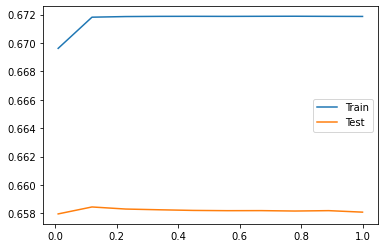

In [91]:
draw_learning_curve(param_values)

C=0.12

### max_iter

In [92]:
def draw_learning_curve(param_values):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(C=0.12,max_iter=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)
        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))
    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.legend()
    plt.show()

In [93]:
param_values = [int(x)for x in np.linspace(1,1000,10)]

param value: 1; train: 0.6425846491308146; test: 0.6363330232268605
param value: 112; train: 0.6718145245600121; test: 0.6584563302526101
param value: 223; train: 0.6718145245600121; test: 0.6584563302526101
param value: 334; train: 0.6718145245600121; test: 0.6584563302526101
param value: 445; train: 0.6718145245600121; test: 0.6584563302526101
param value: 556; train: 0.6718145245600121; test: 0.6584563302526101
param value: 667; train: 0.6718145245600121; test: 0.6584563302526101
param value: 778; train: 0.6718145245600121; test: 0.6584563302526101
param value: 889; train: 0.6718145245600121; test: 0.6584563302526101
param value: 1000; train: 0.6718145245600121; test: 0.6584563302526101


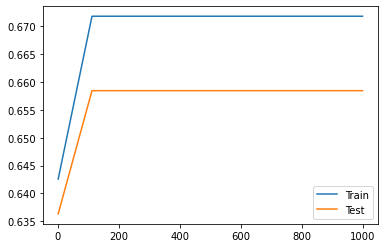

In [94]:
draw_learning_curve(param_values)

n_iter = 100

In [98]:
def draw_learning_curve(param_values):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(C=0.12,tol=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)
        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))
    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.legend()
    plt.show()

In [99]:
param_values = [float(x)for x in np.linspace(0.00001,0.001,10)]

param value: 1e-05; train: 0.6718145245600121; test: 0.6584563302526101
param value: 0.00012; train: 0.6718145245600121; test: 0.6584563302526101
param value: 0.00023; train: 0.6718145245600121; test: 0.6584563302526101
param value: 0.00034; train: 0.6718145245600121; test: 0.6584563302526101
param value: 0.00045000000000000004; train: 0.6718145245600121; test: 0.6584563302526101
param value: 0.0005600000000000001; train: 0.6718145245600121; test: 0.6584563302526101
param value: 0.00067; train: 0.6718145245600121; test: 0.6584563302526101
param value: 0.0007800000000000001; train: 0.6718145245600121; test: 0.6584563302526101
param value: 0.0008900000000000001; train: 0.6718145245600121; test: 0.6584563302526101
param value: 0.001; train: 0.6718145245600121; test: 0.6584563302526101


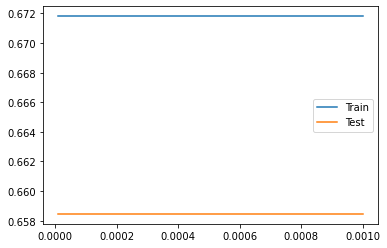

In [100]:
draw_learning_curve(param_values)

## GridSearchCV

In [102]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet']
C = np.linspace(0.1,0.5,5) # Inverse of regularization strength; smaller values specify stronger regularization.
solver = ['newton-cg','lbfgs','liblinear','sag','saga']
hyperparameters = dict(penalty=penalty, C=C,solver=solver)
# Inisiasi model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
model = GridSearchCV(logres, hyperparameters, cv=10,scoring='roc_auc',n_jobs=-1)

# Fitting Model & Evaluation
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(print(model.best_params_))

{'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
None


In [765]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C= 0.5,penalty= 'l2', solver ='lbfgs')

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
pred_proba = clf.predict_proba(features_test)[:,1]

from sklearn.metrics import accuracy_score
accuracy_train_lr_grid = accuracy_score(pred_train,label_train)
accuracy_test_lr_grid = accuracy_score(pred_test,label_test)

from sklearn.metrics import precision_score
precision_train_lr_grid = precision_score(pred_train,label_train)
precision_test_lr_grid = precision_score(pred_test,label_test)

from sklearn.metrics import recall_score
recall_train_lr_grid = recall_score(pred_train,label_train)
recall_test_lr_grid = recall_score(pred_test,label_test)

from sklearn.metrics import f1_score
f1_train_lr_grid = f1_score(pred_train,label_train)
f1_test_lr_grid = f1_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train_lr_grid = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test_lr_grid = metrics.auc(fpr,tpr)
auc_overfitting_lr = auc_test_lr_grid-auc_train_lr_grid

print('Precision Test :',precision_test_lr*100,'%')
print('Precision Train :',precision_train_lr*100,'%')
print('AUC Train:',auc_test_lr*100,'%')
print('AUC Test:',auc_train_lr*100,'%')

Precision Test : 62.18299353555445 %
Precision Train : 64.57733052808233 %
AUC Train: 65.80916038672467 %
AUC Test: 67.1867302375366 %


## Evaluation for Optimization

In [801]:
kesimpulan = pd.DataFrame({'Model':['Base Model','GridSearchCV'],
                            'AUC Test':list(np.array([auc_test_lr,auc_test_lr_grid])*100),
                            'AUC Train':list(np.array([auc_train_lr,auc_train_lr_grid])*100),
                            'Precision Test':list(np.array([precision_test_lr,precision_test_lr_grid])*100),
                            'Precision Train':list(np.array([precision_train_lr,precision_train_lr_grid])*100)})
kesimpulan.sort_values('AUC Test',ascending=False)

,Model,AUC Test,AUC Train,Precision Test,Precision Train
1,GridSearchCV,65.838868,67.086852,62.381900,64.440359
0,Base Model,65.809160,67.186730,62.182994,64.577331


In [802]:
kesimpulan.to_excel('summary_hyperparameter.xlsx')

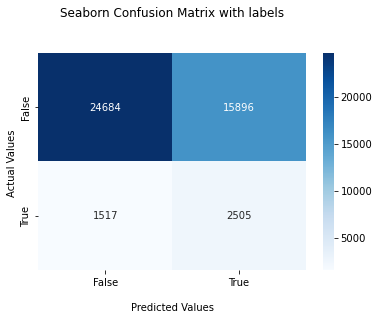

In [145]:
y_pred = clf.predict(features_test)
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues',
                fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
#ROC Curve
#define metrics
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

# Feature Importance

In [815]:
importance = np.absolute(clf.coef_[0])

In [816]:
column_importance =features_test.columns.tolist()

In [823]:
imp = pd.DataFrame({'Feature':column_importance,'Value':importance})
imp = imp.sort_values('Value',ascending=False)[:5]

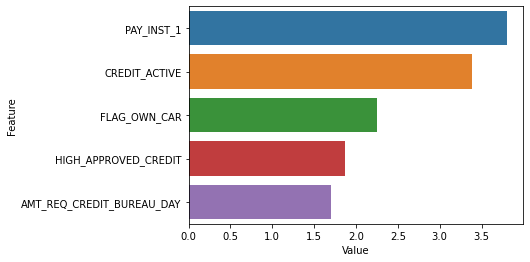

In [825]:
sns.barplot(y='Feature',x='Value',data=imp)
plt.show()

In [895]:
df_selected = pd.read_csv('train_features.csv')
df_selected

,Unnamed: 0,SK_ID_CURR,TARGET,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,HIGH_APPROVED_CREDIT,HIGH_RATE_DOWN_PAYMENT,CREDIT_ACTIVE,CREDIT_DAY_OVERDUE,Consumer credit,Car loan,Mortgage,Microloan,PAY_INST_1,CNT_DIFF
0,0,100002,1,N,0,202500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,...,179055.0,0.000000,2.0,0.0,4.0,0.0,0.0,0.0,0.0,-171.0
1,1,100003,0,N,0,270000.0,Family,State servant,Higher education,Married,...,1035882.0,0.100061,1.0,0.0,2.0,0.0,0.0,0.0,0.0,-121.0
2,2,100004,0,Y,0,67500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,...,20106.0,0.212008,0.0,0.0,2.0,0.0,0.0,0.0,0.0,-6.0
3,3,100006,0,N,0,135000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,...,906615.0,0.217830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-67.0
4,4,100007,0,N,0,121500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,...,284400.0,0.218890,0.0,0.0,1.0,0.0,0.0,0.0,4.0,-420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223003,307501,456245,0,N,3,81000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,...,116077.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0
223004,307503,456247,0,N,0,112500.0,Unaccompanied,Commercial associate,Higher education,Single / not married,...,98145.0,0.105099,3.0,0.0,9.0,0.0,1.0,0.0,2.0,-96.0
223005,307506,456251,0,N,0,157500.0,Unaccompanied,Working,Secondary / secondary special,Separated,...,40455.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-28.0
223006,307509,456254,1,N,0,171000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,...,247423.5,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-91.0


## Pay Installment

Fitur yang menunjukan jumlah pembayaran yang telat 1-16 hari

In [860]:
df_pay_inst = df_selected.groupby(['PAY_INST_1'])['SK_ID_CURR'].count().reset_index()
df_pay_inst_1 = df_selected[df_selected['TARGET']==1]
df_pay_inst_1 = df_pay_inst_1.groupby(['PAY_INST_1'])['SK_ID_CURR'].count().reset_index()

In [863]:
df_pay_inst['%TARGET'] =  df_pay_inst_1['SK_ID_CURR']/df_pay_inst['SK_ID_CURR']*100

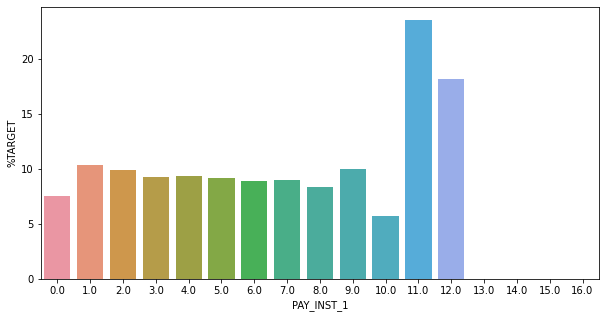

In [870]:
plt.figure(figsize=(10,5))
sns.barplot(x='PAY_INST_1',y='%TARGET',data=df_pay_inst)
plt.show()

**Data Insight**

Applicant yang memiliki banyak data historis penunggakan pembayaran memiliki kemungkinan default yang lebih tinggi

## CREDIT_ACTIVE

Fitur yang menunjukan jumlah kredit aktif yang dimiliki applicant

In [872]:
CREDIT_ACTIVE = df_selected.groupby(['CREDIT_ACTIVE'])['SK_ID_CURR'].count().reset_index()
CREDIT_ACTIVE_1 = df_selected[df_selected['TARGET']==1]
CREDIT_ACTIVE_1 = CREDIT_ACTIVE_1.groupby(['CREDIT_ACTIVE'])['SK_ID_CURR'].count().reset_index()
CREDIT_ACTIVE['%TARGET'] =  CREDIT_ACTIVE_1['SK_ID_CURR']/CREDIT_ACTIVE['SK_ID_CURR']*100

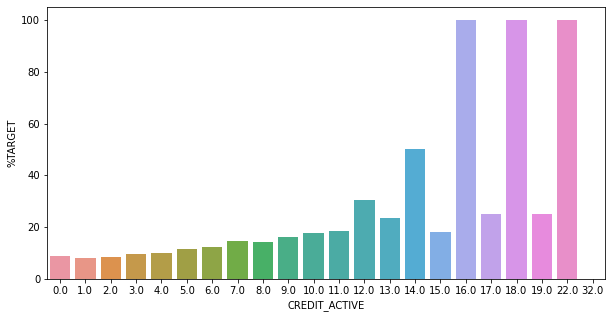

In [873]:
plt.figure(figsize=(10,5))
sns.barplot(x='CREDIT_ACTIVE',y='%TARGET',data=CREDIT_ACTIVE)
plt.show()

**Data Insight**

Semakin banyak Applicant yang memiliki jumlah kredit aktif semakin banyak default applicant

## High Approved Credit

Fitur yang menunjukan data historical jumlah kredit yang tertinggi yang diterima applicant

In [926]:
bins = np.linspace(min(df_selected['HIGH_APPROVED_CREDIT']), max(df_selected['HIGH_APPROVED_CREDIT']), 6)

In [927]:
bins

array([      0. ,  820870.2, 1641740.4, 2462610.6, 3283480.8, 4104351. ])

In [928]:
kategori = ['Very Low','Low','Mid','High','Very High']

In [929]:
df_selected['HIGH_APPROVED_CREDIT_bins'] = pd.cut(df_selected['HIGH_APPROVED_CREDIT'], bins, labels=kategori, include_lowest=True)

In [930]:
df_selected.groupby('HIGH_APPROVED_CREDIT_bins')['TARGET'].sum().reset_index()

,HIGH_APPROVED_CREDIT_bins,TARGET
0,Very Low,17804
1,Low,2224
2,Mid,261
3,High,56
4,Very High,6


In [931]:
HIGH_APPROVED_CREDIT_bins = df_selected.groupby(['HIGH_APPROVED_CREDIT_bins'])['SK_ID_CURR'].count().reset_index()
HIGH_APPROVED_CREDIT_bins_1 = df_selected[df_selected['TARGET']==1]
HIGH_APPROVED_CREDIT_bins_1 = HIGH_APPROVED_CREDIT_bins_1.groupby(['HIGH_APPROVED_CREDIT_bins'])['SK_ID_CURR'].count().reset_index()
HIGH_APPROVED_CREDIT_bins['%TARGET'] =  HIGH_APPROVED_CREDIT_bins_1['SK_ID_CURR']/HIGH_APPROVED_CREDIT_bins['SK_ID_CURR']*100

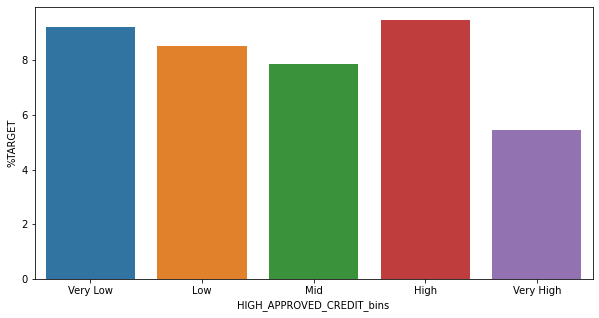

In [932]:
plt.figure(figsize=(10,5))
sns.barplot(x='HIGH_APPROVED_CREDIT_bins',y='%TARGET',data=HIGH_APPROVED_CREDIT_bins)
plt.show()

# Credit Scoring

In [106]:
from collections import OrderedDict
import pandas as pd
import sys
%matplotlib inline
    
def plot_pandas_style(styler):
    from IPython.core.display import HTML
    html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
    return HTML(html)

def highlight_max(s,color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: {}'.format(color) if v else '' for v in is_max]

def decile_labels(agg1,label,color='skyblue'):
    agg_dummy = pd.DataFrame(OrderedDict((('TOTAL',0),('TARGET',0),('NONTARGET',0),('PCT_TAR',0),('CUM_TAR',0),('CUM_NONTAR',0),('DIST_TAR',0),('DIST_NONTAR',0),('SPREAD',0))),index=[0])
    agg1 = agg1.append(agg_dummy).sort_index()
    agg1.index.name = label
    agg1 = agg1.style.apply(highlight_max, color = 'yellow', subset=['SPREAD'])
    agg1.bar(subset=['TARGET'], color='{}'.format(color))
    agg1.bar(subset=['TOTAL'], color='{}'.format(color))
    agg1.bar(subset=['PCT_TAR'], color='{}'.format(color))
    return(agg1)

def deciling(data,decile_by,target,nontarget):
    inputs = list(decile_by)
    inputs.extend((target,nontarget))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['TOTAL'] = grouped.sum()[nontarget] + grouped.sum()[target]
    agg1['TARGET'] = grouped.sum()[target]
    agg1['NONTARGET'] = grouped.sum()[nontarget]
    agg1['PCT_TAR'] = grouped.mean()[target]*100
    agg1['CUM_TAR'] = grouped.sum()[target].cumsum()
    agg1['CUM_NONTAR'] = grouped.sum()[nontarget].cumsum()
    agg1['DIST_TAR'] = agg1['CUM_TAR']/agg1['TARGET'].sum()*100
    agg1['DIST_NONTAR'] = agg1['CUM_NONTAR']/agg1['NONTARGET'].sum()*100
    agg1['SPREAD'] = (agg1['DIST_TAR'] - agg1['DIST_NONTAR'])
    agg1 = decile_labels(agg1,'DECILE',color='skyblue')
    return(plot_pandas_style(agg1))

In [146]:
def scoring(features,clf,target):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    score['TARGET'] = target
    score['NONTARGET'] = 1 - target
    return(score)

In [147]:
scores_train = scoring(features_train,clf,label_train)
scores_test = scoring(features_test,clf,label_test)

In [148]:
deciling(scores_train,['DECILE'],'TARGET','NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
DECILE,,,,,,,,,
0.0,0,0,0,0.000000,0,0,0.000000,0.000000,0.000000
1.0,32416,23356,9060,72.050839,23356,9060,14.410435,5.589936,8.820499
2.0,32415,21723,10692,67.015271,45079,19752,27.813323,12.186800,15.626523
3.0,32415,20082,12333,61.952800,65161,32085,40.203730,19.796146,20.407584
4.0,32416,18959,13457,58.486550,84120,45542,51.901257,28.098990,23.802267
5.0,32415,17373,15042,53.595558,101493,60584,62.620236,37.379764,25.240472
6.0,32415,15878,16537,48.983495,117371,77121,72.416814,47.582939,24.833875
7.0,32416,14264,18152,44.002962,131635,95273,81.217569,58.782554,22.435015
8.0,32415,12568,19847,38.772173,144203,115120,88.971908,71.027968,17.943940


Distribusi decile binning sudah baik

In [149]:
credit_scoring = scores_train.groupby('DECILE').agg({'SCORE':['min','max']}).reset_index()

In [150]:
credit_scoring.columns = ['DECILE','MIN','MAX']

In [933]:
credit_scoring.to_excel('credit_scoring.xlsx')

In [152]:
max_score = credit_scoring['MAX']
max_score = max_score.to_list()

In [153]:
X_test_col = X_test.copy()
X_test_col['pred_prob'] = pred_proba

In [154]:
X_test_col

,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OWN_CAR_AGE,OCCUPATION_TYPE,...,HIGH_RATE_DOWN_PAYMENT,CREDIT_ACTIVE,CREDIT_DAY_OVERDUE,Consumer credit,Car loan,Mortgage,Microloan,PAY_INST_1,CNT_DIFF,pred_prob
105300,-0.153449,-0.001565,-0.018473,0.015718,0.101532,0.127826,-0.077249,-0.034,-0.146415,0.270592,...,0.150269,0.074739,-0.012131,-0.112451,0.004051,0.002465,-0.008688,-0.028428,0.029266,0.472161
70749,0.080853,-0.001565,0.083157,-0.095226,-0.160658,-0.038736,0.191628,-0.034,0.069708,0.274130,...,0.150269,-0.067438,-0.012131,0.138249,0.004051,0.002465,-0.008688,-0.028428,0.029266,0.612203
127323,-0.153449,-0.001565,-0.018473,0.015718,0.101532,0.127826,0.191628,-0.034,-0.146415,-0.367208,...,0.150269,0.074739,-0.012131,-0.112451,0.004051,0.002465,-0.008688,0.054940,-0.160606,0.448355
58113,0.080853,-0.001565,0.083157,-0.095226,0.101532,0.127826,0.191628,-0.034,0.069708,0.195954,...,0.150269,0.074739,-0.012131,-0.108501,0.004051,0.002465,-0.008688,-0.028428,-0.160606,0.350407
150499,0.080853,-0.001565,-0.185070,0.015718,0.101532,0.127826,-0.077249,-0.034,0.069708,-0.081765,...,0.150269,-0.067438,-0.012131,-0.112451,0.004051,0.002465,-0.008688,0.054940,0.029266,0.640676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233671,-0.153449,-0.001565,-0.185070,0.015718,0.101532,0.127826,-0.077249,-0.034,-0.146415,-0.367208,...,0.150269,-0.067438,-0.012131,0.138249,0.004051,0.002465,-0.008688,-0.028428,0.115908,0.337741
122832,0.080853,-0.001565,0.047248,0.015718,0.101532,0.127826,0.191628,-0.034,0.069708,0.211387,...,-0.171366,-0.067438,-0.012131,-0.017241,0.004051,0.002465,-0.008688,0.054940,0.029266,0.469426
177830,0.080853,-0.001565,0.047248,0.015718,-0.160658,-0.038736,-0.077249,-0.034,0.069708,0.070777,...,0.150269,-0.067438,-0.012131,0.138249,0.004051,0.002465,-0.008688,-0.028428,0.029266,0.641940
20772,0.080853,-0.001565,0.047248,0.015718,0.101532,0.127826,0.191628,-0.034,0.069708,0.070777,...,0.150269,-0.067438,-0.012131,-0.017241,0.004051,0.002465,-0.008688,-0.028428,-0.160606,0.473465


In [155]:
array= np.array(X_test_col['pred_prob'])
bins= max_score
bin_indices  = np.digitize(array, bins)
bin_indices = list(bin_indices)

In [156]:
X_test_col['DECILE'] = bin_indices

<AxesSubplot:>

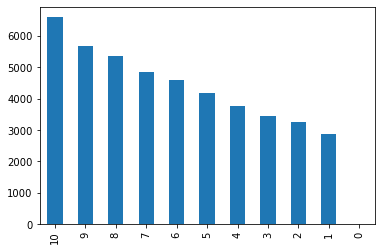

In [157]:
X_test_col['DECILE'].value_counts().plot(kind='bar')

In [219]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,FLAG_OWN_CAR,N,N,141159,13860,0.098187,127299,0.901813,0.681048,0.628150,0.080853,0.012394
1,FLAG_OWN_CAR,Y,Y,81849,6491,0.079305,75358,0.920695,0.318952,0.371850,-0.153449,0.012394
2,CNT_CHILDREN,0,1,195123,17781,0.091127,177342,0.908873,0.873716,0.875085,-0.001565,0.000017
3,CNT_CHILDREN,2,19,27885,2570,0.092164,25315,0.907836,0.126284,0.124915,0.010894,0.000017
4,AMT_INCOME_TOTAL,25650.0,112500.0,68380,6728,0.098391,61652,0.901609,0.330598,0.304218,0.083157,0.009707
...,...,...,...,...,...,...,...,...,...,...,...,...
115,PAY_INST_1,0.0,1.0,148662,13220,0.088927,135442,0.911073,0.649600,0.668331,-0.028428,0.001562
116,PAY_INST_1,2.0,16.0,74346,7131,0.095916,67215,0.904084,0.350400,0.331669,0.054940,0.001562
117,CNT_DIFF,-3109.0,-165.0,74546,5873,0.078784,68673,0.921216,0.288585,0.338863,-0.160606,0.013047
118,CNT_DIFF,-164.0,-56.0,74312,6964,0.093713,67348,0.906287,0.342194,0.332325,0.029266,0.013047


# Impact of Model

## Profitability General Modeling

In [160]:
X_test_col['y_pred'] = pred_test
X_test_col['y_test'] = label_test

In [165]:
df_score = X_test_col.groupby('DECILE')['y_test'].count().reset_index()

In [170]:
df_score.columns = ['DECILE','Count of Applicants']

In [171]:
df_score

,DECILE,Count of Applicants
0,0,1
1,1,2870
2,2,3238
3,3,3453
4,4,3771
5,5,4174
6,6,4605
7,7,4839
8,8,5367
9,9,5684


<AxesSubplot:xlabel='DECILE', ylabel='Count of Applicants'>

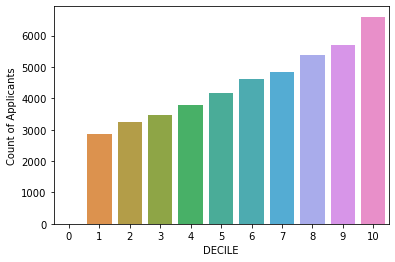

In [172]:
sns.barplot(x='DECILE',y='Count of Applicants',data=df_score)

In [173]:
credit_scoring 

,DECILE,MIN,MAX
0,1.0,0.689451,0.952068
1,2.0,0.633165,0.689449
2,3.0,0.588777,0.633164
3,4.0,0.548202,0.588777
4,5.0,0.507809,0.548202
5,6.0,0.465580,0.507809
6,7.0,0.419799,0.465578
7,8.0,0.366338,0.419796
8,9.0,0.295694,0.366336
9,10.0,0.031391,0.295691


DECILE 1 menunjukan bahwa applicant memiliki high risk. Sehingga dapat ditolak applicant tersebut.

In [132]:
df_applicant = pd.read_csv('application_train.csv')

In [184]:
rata_rata_kredit = df_applicant['AMT_CREDIT'].mean()

# Impact for Business Metrics

In [431]:
df_app = pd.read_csv('train_features.csv')
df_raw = pd.read_csv('application_train.csv')

In [434]:
amount_credit = df_raw[['SK_ID_CURR','AMT_CREDIT']]

In [435]:
df_app = df_app.merge(amount_credit,how='left',on='SK_ID_CURR')

In [436]:
df_app

,Unnamed: 0,SK_ID_CURR,TARGET,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,HIGH_RATE_DOWN_PAYMENT,CREDIT_ACTIVE,CREDIT_DAY_OVERDUE,Consumer credit,Car loan,Mortgage,Microloan,PAY_INST_1,CNT_DIFF,AMT_CREDIT
0,0,100002,1,N,0,202500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,...,0.000000,2.0,0.0,4.0,0.0,0.0,0.0,0.0,-171.0,406597.5
1,1,100003,0,N,0,270000.0,Family,State servant,Higher education,Married,...,0.100061,1.0,0.0,2.0,0.0,0.0,0.0,0.0,-121.0,1293502.5
2,2,100004,0,Y,0,67500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,...,0.212008,0.0,0.0,2.0,0.0,0.0,0.0,0.0,-6.0,135000.0
3,3,100006,0,N,0,135000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,...,0.217830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-67.0,312682.5
4,4,100007,0,N,0,121500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,...,0.218890,0.0,0.0,1.0,0.0,0.0,0.0,4.0,-420.0,513000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223003,307501,456245,0,N,3,81000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,269550.0
223004,307503,456247,0,N,0,112500.0,Unaccompanied,Commercial associate,Higher education,Single / not married,...,0.105099,3.0,0.0,9.0,0.0,1.0,0.0,2.0,-96.0,345510.0
223005,307506,456251,0,N,0,157500.0,Unaccompanied,Working,Secondary / secondary special,Separated,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-28.0,254700.0
223006,307509,456254,1,N,0,171000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,...,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-91.0,370107.0


In [437]:
feature_app = df_app.drop('TARGET',axis=1)
label_app = df_app['TARGET']

In [438]:
feature_app_train,feature_app_test, label_train,label_test = train_test_split(feature_app,label_app,test_size=0.2, random_state=21)

In [439]:
feature_app_test['y_pred'] = pred_test
feature_app_test['y_test'] = label_test

In [440]:
feature_app_test.columns

Index(['Unnamed: 0', 'SK_ID_CURR', 'FLAG_OWN_CAR', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AGE', 'WORKDAY', 'Consumer Loans',
       'Cash Loans', 'Revolving Loans', 'HIGH_APPROVED_CREDIT',
       'HIGH_RATE_DOWN_PAYMENT', 'CREDIT_ACTIVE', 'CREDIT_DAY_OVERDUE',
       'Consumer credit', 'Car loan', 'Mortgage', 'Microloan', 'PAY_INST_1',
       'CNT_DIFF', 'AMT_CREDIT', 'y_pred', 'y_test'],
      dtype='object')

In [458]:
total_kredit_konvensional = feature_app_test['AMT_CREDIT'].sum()
total_kredit_default = feature_app_test[feature_app_test['y_test']==1]['AMT_CREDIT'].sum()
profitability_konvensional = total_kredit_konvensional-total_kredit_default
percentage_profitability_konvensional = profitability_konvensional/total_kredit_konvensional

In [459]:
total_kredit_model = feature_app_test['AMT_CREDIT'][feature_app_test['y_pred']==1].sum()
total_kredit_default_model = feature_app_test[(feature_app_test['y_pred']==1)&(feature_app_test['y_test']==1)]['AMT_CREDIT'].sum()
profitability_model = total_kredit_model-total_kredit_default_model
percentage_profitability_model = profitability_model/total_kredit_model

In [468]:
amount_of_default_credit = pd.DataFrame({'Metode':['Conventional','Model'],
                            'amount of default credit':[total_kredit_default,total_kredit_default_model]})

In [488]:
amount_of_default_credit

,Metode,amount of default credit
0,Conventional,2.171364e+09
1,Model,1.207133e+09


In [469]:
amount_of_default_credit.to_excel('amount of default credit.xlsx')

<AxesSubplot:xlabel='Metode', ylabel='amount of default credit'>

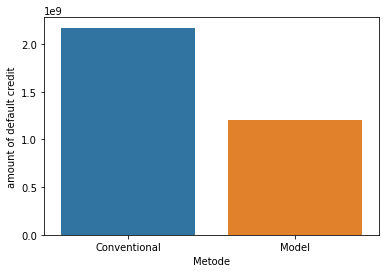

In [470]:
sns.barplot(x='Metode',y='amount of default credit',data=amount_of_default_credit)

In [477]:
total_app = feature_app_test.shape[0]
default_app = feature_app_test[feature_app_test['y_test']==1].shape[0]

In [483]:
percent_default = default_app/total_app

In [481]:
total_model = feature_app_test[(feature_app_test['y_pred']==0)].shape[0]
default_model = feature_app_test[(feature_app_test['y_pred']==0)&(feature_app_test['y_test']==1)].shape[0]

In [484]:
percent_default_model = default_model/total_model

In [485]:
default_impact = pd.DataFrame({'Metode':['Conventional','Model'],
                            'default_percent':[percent_default,percent_default_model]})

<AxesSubplot:xlabel='Metode', ylabel='default_percent'>

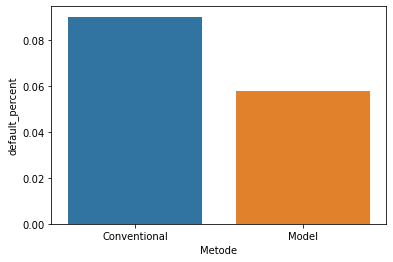

In [486]:
sns.barplot(x='Metode',y='default_percent',data=default_impact)

In [487]:
default_impact

,Metode,default_percent
0,Conventional,0.090175
1,Model,0.057899


# Testing for New Test Data

## Preparation

In [672]:
df_test = pd.read_csv('application_test.csv')
df_train_selected = pd.read_csv('train_selected.csv')
column_selected = df_train_selected.columns.tolist()
column_selected.remove('TARGET')
df_test = df_test[column_selected]

In [673]:
df_test

,SK_ID_CURR,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,N,0,135000.0,Unaccompanied,Working,Higher education,Married,House / apartment,-19241,-2329,NaN,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,N,0,99000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,-18064,-4469,NaN,Low-skill Laborers,2.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Y,0,202500.0,NaN,Working,Higher education,Married,House / apartment,-20038,-4458,5.0,Drivers,2.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,N,2,315000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,-13976,-1866,NaN,Sales staff,4.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Y,1,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,-13040,-2191,16.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,N,0,121500.0,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,-19970,-5169,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,N,2,157500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,-11186,-1149,NaN,Sales staff,4.0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Y,1,202500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,-15922,-3037,4.0,NaN,3.0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,N,0,225000.0,Family,Commercial associate,Higher education,Married,House / apartment,-13968,-2731,NaN,Managers,2.0,0.0,0.0,0.0,0.0,0.0,2.0


In [674]:
df_test['AGE'] = -df_test['DAYS_BIRTH']/365
df_test['WORKDAY'] =  -df_test['DAYS_EMPLOYED']/365
df_test.drop(['DAYS_BIRTH','DAYS_EMPLOYED'],axis=1,inplace=True)

In [675]:
consumer_loans = prev_app[prev_app['NAME_CONTRACT_TYPE']=='Consumer loans']
consumer_loans = consumer_loans.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
consumer_loans = consumer_loans.reset_index()
consumer_loans['Consumer Loans'] = consumer_loans['SK_ID_PREV']
consumer_loans.drop('SK_ID_PREV',axis=1,inplace=True)
df_test = df_test.merge(consumer_loans,how='left',on='SK_ID_CURR')

In [676]:
cash_loans = prev_app[prev_app['NAME_CONTRACT_TYPE']=='Cash loans']
cash_loans = cash_loans.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
cash_loans = cash_loans.reset_index()
cash_loans['Cash Loans'] = cash_loans['SK_ID_PREV']
cash_loans.drop('SK_ID_PREV',axis=1,inplace=True)
df_test = df_test.merge(cash_loans,how='left',on='SK_ID_CURR')

In [677]:
revolving_loans = prev_app[prev_app['NAME_CONTRACT_TYPE']=='Revolving loans']
revolving_loans = revolving_loans.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
revolving_loans = revolving_loans.reset_index()
revolving_loans['Revolving Loans'] = revolving_loans['SK_ID_PREV']
revolving_loans.drop('SK_ID_PREV',axis=1,inplace=True)
df_test = df_test.merge(revolving_loans,how='left',on='SK_ID_CURR')

In [678]:
high_approved_credit = prev_app.groupby('SK_ID_CURR')['AMT_CREDIT'].max().reset_index()
high_approved_credit['HIGH_APPROVED_CREDIT'] = high_approved_credit['AMT_CREDIT']
high_approved_credit.drop('AMT_CREDIT',axis=1,inplace=True)
df_test = df_test.merge(high_approved_credit,how='left',on='SK_ID_CURR')

In [679]:
average_approved_credit = prev_app.groupby('SK_ID_CURR')['AMT_CREDIT'].mean().reset_index()
average_approved_credit['AVERAGE_APPROVED_CREDIT'] = average_approved_credit['AMT_CREDIT']
average_approved_credit.drop('AMT_CREDIT',axis=1,inplace=True)
df_test = df_test.merge(average_approved_credit,how='left',on='SK_ID_CURR')

In [680]:
flag = prev_app[prev_app['FLAG_LAST_APPL_PER_CONTRACT']=='Y']
flag = flag.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().reset_index()
flag['FLAG'] = flag['SK_ID_PREV']
flag.drop('SK_ID_PREV',axis=1,inplace=True)
df_test = df_test.merge(flag,how='left',on='SK_ID_CURR')

In [681]:
high_downpayment = prev_app.groupby('SK_ID_CURR')['RATE_DOWN_PAYMENT'].max().reset_index()
high_downpayment['HIGH_RATE_DOWN_PAYMENT'] = high_downpayment['RATE_DOWN_PAYMENT']
high_downpayment.drop('RATE_DOWN_PAYMENT',axis=1,inplace=True)
df_test = df_test.merge(high_downpayment,how='left',on='SK_ID_CURR')

In [682]:
average_downpayment = prev_app.groupby('SK_ID_CURR')['RATE_DOWN_PAYMENT'].mean().reset_index()
average_downpayment['AVERAGE_RATE_DOWN_PAYMENT'] = average_downpayment['RATE_DOWN_PAYMENT']
average_downpayment.drop('RATE_DOWN_PAYMENT',axis=1,inplace=True)
df_test = df_test.merge(average_downpayment,how='left',on='SK_ID_CURR')

In [683]:
cards = prev_app[prev_app['NAME_PORTFOLIO']=='Cards']
cards = cards.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
cards = cards.reset_index()
cards['Cards'] = cards['SK_ID_PREV']
cards.drop('SK_ID_PREV',axis=1,inplace=True)
df_test = df_test.merge(cards,how='left',on='SK_ID_CURR')

In [684]:
POS = prev_app[prev_app['NAME_PORTFOLIO']=='POS']
POS = POS.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
POS = POS.reset_index()
POS['POS'] = POS['SK_ID_PREV']
POS.drop('SK_ID_PREV',axis=1,inplace=True)
df_test = df_test.merge(POS,how='left',on='SK_ID_CURR')

In [685]:
Cash = prev_app[prev_app['NAME_PORTFOLIO']=='Cash']
Cash = Cash.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
Cash = Cash.reset_index()
Cash['Cash'] = Cash['SK_ID_PREV']
Cash.drop('SK_ID_PREV',axis=1,inplace=True)
df_test = df_test.merge(Cash,how='left',on='SK_ID_CURR')

In [686]:
credit_active = bureau[bureau['CREDIT_ACTIVE']=='Active']
credit_active = credit_active.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique().reset_index()
credit_active['CREDIT_ACTIVE'] = credit_active['SK_ID_BUREAU']
credit_active.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_test = df_test.merge(credit_active,how='left',on='SK_ID_CURR')

In [687]:
credit_overdue = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].sum().reset_index()
df_test = df_test.merge(credit_overdue,how='left',on='SK_ID_CURR')

In [688]:
credit_card = bureau[bureau['CREDIT_TYPE']=='Credit card']
credit_card = credit_card.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()
credit_card = credit_card.reset_index()
credit_card['Credit card'] = credit_card['SK_ID_BUREAU']
credit_card.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_test = df_test.merge(credit_card,how='left',on='SK_ID_CURR')

In [689]:
Microloan = bureau[bureau['CREDIT_TYPE']=='Microloan']
Microloan = Microloan.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()
Microloan = Microloan.reset_index()
Microloan['Microloan'] = Microloan['SK_ID_BUREAU']
Microloan.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_test = df_test.merge(Microloan,how='left',on='SK_ID_CURR')

In [690]:
consumer_credit = bureau[bureau['CREDIT_TYPE']=='Consumer credit']
consumer_credit = consumer_credit.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()
consumer_credit = consumer_credit.reset_index()
consumer_credit['Consumer credit'] = consumer_credit['SK_ID_BUREAU']
consumer_credit.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_test = df_test.merge(consumer_credit,how='left',on='SK_ID_CURR')

In [691]:
car_loan = bureau[bureau['CREDIT_TYPE']=='Car loan']
car_loan = car_loan.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()
car_loan = car_loan.reset_index()
car_loan['Car loan'] = car_loan['SK_ID_BUREAU']
car_loan.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_test = df_test.merge(car_loan,how='left',on='SK_ID_CURR')

In [692]:
Mortgage = bureau[bureau['CREDIT_TYPE']=='Mortgage']
Mortgage = Mortgage.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()
Mortgage = Mortgage.reset_index()
Mortgage['Mortgage'] = Mortgage['SK_ID_BUREAU']
Mortgage.drop('SK_ID_BUREAU',axis=1,inplace=True)
df_test = df_test.merge(Mortgage,how='left',on='SK_ID_CURR')

In [693]:
PAY_DAY = installment[['SK_ID_CURR','SK_ID_PREV','PAY_DAY']]
PAYDAY_1 = PAY_DAY[(PAY_DAY['PAY_DAY']<1)&(PAY_DAY['PAY_DAY']>=-30)]
PAYDAY_1 = PAYDAY_1.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().reset_index()
PAYDAY_1['PAY_INST_1'] = PAYDAY_1['SK_ID_PREV']
PAYDAY_1.drop('SK_ID_PREV',axis=1,inplace=True)
df_test = df_test.merge(PAYDAY_1,how='left',on='SK_ID_CURR')

In [694]:
PAY_DAY = installment[['SK_ID_CURR','SK_ID_PREV','PAY_DAY']]
PAYDAY_30 = PAY_DAY[(PAY_DAY['PAY_DAY']<30)]
PAYDAY_30 = PAYDAY_30.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().reset_index()
PAYDAY_30['PAY_INST_30'] = PAYDAY_30['SK_ID_PREV']
PAYDAY_30.drop('SK_ID_PREV',axis=1,inplace=True)
df_test = df_test.merge(PAYDAY_30,how='left',on='SK_ID_CURR')

In [695]:
cnt_diff = posh.groupby('SK_ID_CURR')['CNT_DIFF'].sum().reset_index()
df_test = df_test.merge(cnt_diff,how='left',on='SK_ID_CURR')

In [696]:
df_test

,SK_ID_CURR,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OWN_CAR_AGE,...,CREDIT_ACTIVE,CREDIT_DAY_OVERDUE,Credit card,Microloan,Consumer credit,Car loan,Mortgage,PAY_INST_1,PAY_INST_30,CNT_DIFF
0,100001,N,0,135000.0,Unaccompanied,Working,Higher education,Married,House / apartment,NaN,...,3.0,0.0,NaN,NaN,7.0,NaN,NaN,1.0,2.0,-23.0
1,100005,N,0,99000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,NaN,...,2.0,0.0,1.0,NaN,2.0,NaN,NaN,1.0,1.0,-45.0
2,100013,Y,0,202500.0,NaN,Working,Higher education,Married,House / apartment,5.0,...,NaN,0.0,NaN,NaN,2.0,2.0,NaN,3.0,4.0,-219.0
3,100028,N,2,315000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,NaN,...,5.0,0.0,5.0,NaN,7.0,NaN,NaN,1.0,3.0,-317.0
4,100038,Y,1,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,N,0,121500.0,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,NaN,...,2.0,0.0,1.0,1.0,3.0,NaN,NaN,NaN,1.0,-6.0
48740,456222,N,2,157500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,-721.0
48741,456223,Y,1,202500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,4.0,...,1.0,0.0,1.0,NaN,3.0,NaN,1.0,NaN,2.0,-106.0
48742,456224,N,0,225000.0,Family,Commercial associate,Higher education,Married,House / apartment,NaN,...,6.0,0.0,4.0,NaN,13.0,NaN,NaN,1.0,2.0,-229.0


In [697]:
df_test['NAME_TYPE_SUITE'] = df_test['NAME_TYPE_SUITE'].fillna('Unaccompanied')
df_test = df_test.fillna(value=0)
df_test['OCCUPATION_TYPE'] = df_test['OCCUPATION_TYPE'].replace(0,'Others')

In [698]:
columns = df_train.columns.tolist()
columns.remove('TARGET')

In [700]:
df_test = df_test[transform_vars_list]

## Transform

In [759]:
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            df_train[transform_prefix + var] = df_train[var].apply(lambda x: eval(replace_cmd))
            df_test[transform_prefix + var] = df_test[var].apply(lambda x: eval(replace_cmd))
        except:
            df_train[transform_prefix + var] = df_train[var].apply(lambda x: eval(replace_cmd1))
            df_test[transform_prefix + var] = df_test[var].apply(lambda x: eval(replace_cmd1))

## Testing

In [766]:
pred_test = clf.predict(df_test)
pred_proba = clf.predict_proba(df_test)[:,1]

In [767]:
df_test_new = pd.read_csv('application_test.csv')

In [770]:
df_test_new['TARGET'] = pred_test
df_test_new['pred_proba'] = pred_proba

In [772]:
submission = df_test_new[['SK_ID_CURR','pred_proba']]

In [774]:
submission.columns = ['SK_ID_CURR','TARGET']

In [775]:
submission.to_csv('submission.csv')

In [784]:
segment_creditors = df_test_new[['SK_ID_CURR','pred_proba']]

In [778]:
array= np.array(segmen_creditors['pred_proba'])
bins= max_score
bin_indices  = np.digitize(array, bins)
bin_indices = list(bin_indices)

In [785]:
segment_creditors ['DECILE'] = bin_indices

In [787]:
segment_creditors = segment_creditors.groupby('DECILE')['SK_ID_CURR'].count().reset_index()

In [789]:
segment_creditors.columns = ['DECILE','Count of Applicants']

In [934]:
segment_creditors

,DECILE,Count of Applicants
0,0,349
1,1,8031
2,2,2458
3,3,1935
4,4,1871
5,5,2050
6,6,2350
7,7,3131
8,8,4367
9,9,6170


<AxesSubplot:xlabel='DECILE', ylabel='Count of Applicants'>

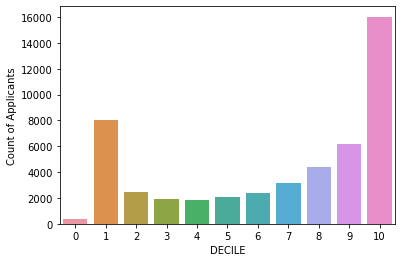

In [790]:
sns.barplot(x='DECILE',y='Count of Applicants',data=segment_creditors)

Applicant dengan DECILE 0 dan 1 dapat ditolak

**Business Recommendation**

Dari total 48.744 applicant ditemukan 8.380 applicant yang memiliki resiko yang tinggi untuk mengalami default. Oleh karena itu applicant tersebut dapat ditolak untuk meminimalisir jumlah default kredit.  